# Risikomodellierung in der Schadenversicherung mit Python

Dieses Notebook dient als Begleitmaterial zur Masterthesis "Risikomodellierung in der Schadenverischerung mit Python". Am einfachsten kann das Notebook interaktiv über Binder ausgeführt werden. Dazu einfach auf den folgenden Button klicken:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Diadochokinetic/fremtpl/HEAD?labpath=Risikomodellierung+in+der+Schadenversicherung+mit+Python.ipynb)

Alternativ kann auch eine eigene Jupyter-Umgebung mit den in `requirements.txt` hinterlegten Abhängigkeiten genutzt werden. Der grundlegende Aufbau wurde inspieriert durch das scikit-learn Tutorial [Tweedie regression on insurance claims](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html).

Es werden verschiedene Modelltypen vorgestellt. Wir betrachten hierbei ältere Modelle, wie das Marginalsummenverfahren nach Bailey, die aktuell überlicherweise verwendeten Generalisierten Linearen Modelle (GLMs), sowie die potentiell für die Risikomodellierung interessanten Gradient Boosting Machines (GBMs). Es wird gezeigt, wie diese Modelle zur Ermittlung der Netto-Risikoprämie verwendet werden können. Dabei werden direkte Modellierungsansätze, sowie kombinierte Ansätze auf Basis der Schadenhäufigkeit und -höhe vorgestellt. Die entwickelten Modelle werden anhand verschiedener Dimensionen bewertet:

- verschiedene Metriken zur Vorhersagequalität
- der Vorhersage des Gesamtschadenaufwands
- der Fähigkeit, Risiken zu ordnen

Schließlich werden verschiedene Methoden zur Erklärung der Modelle vorgestellt.

## Daten

Die in diesem Notebook verwendeten Daten sind die "French Motor Third-Party Liability Claims" Datensätze von [OpenML](https://www.openml.org/). Diese bestehen aus einem separaten Datensatz für die Schadenhäufigkeit: [freMTPL2freq](https://www.openml.org/d/41214) und einem für die Schadenhöhe: [freMTPL2sev](https://www.openml.org/d/41214).

In [2]:
from sklearn.datasets import fetch_openml

# freMTPL2freq dataset from https://www.openml.org/d/41214
df_freq = fetch_openml(data_id=41214, as_frame=True, parser="pandas").data
df_freq["IDpol"] = df_freq["IDpol"].astype(int)
df_freq.set_index("IDpol", inplace=True)

# freMTPL2sev dataset from https://www.openml.org/d/41215
df_sev = fetch_openml(data_id=41215, as_frame=True, parser="pandas").data

### Datenaufbereitung

Es gibt einige Aufbereitungsschritte, die für beide Datensätze durchgeführt werden müssen, andere Schritte müssen nur für bestimmte Modelltypen durchgeführt werden.

#### Allgemeine Schritte

Für die folgenden Modellierungszwecke werden die beiden Datensätze auf Basis der Policy-ID zusammengeführt. Eine Police kann hierbei mehrere Schäden haben, diese müssen vor der Zusammenführung aggregiert werden.

In [3]:
# sum ClaimAmount over identical IDs
df_sev = df_sev.groupby("IDpol").sum()

df = df_freq.join(df_sev, how="left")
df["ClaimAmount"] = df["ClaimAmount"].fillna(0)

# unquote string fields
for column_name in df.columns[df.dtypes.values == object]:
    df[column_name] = df[column_name].str.strip("'")

Die Schadenanzahl wird später als Gewicht in der Modellierung der Schadenhähe verwendet. Da hierbei nur strikt positive Werte verwendet werden können, wird die Schadenanzahl für Schäden ohne Aufwand auf 0 gesetzt.

In [4]:
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

Außergewöhnlich hohe Werte für die Anzahl der Schäden, die Jahreseinheiten und die Schadenhöhe werden abgeschnitten. Dies ist notwendig, um die Modelle zu stabilisieren und zu verhindern, dass sie von Ausreißern dominiert werden.

Beachte: In einem realen Szenario können wir den Schadenaufwand nicht einfach kappen und den gekappten Teil ignorieren. Wir müssten den überschüssigen Schadenaufwand auf die anderen Schäden verteilen. Es gibt verschiedene Möglichkeiten, dies zu tun. Dies wird hier aus Gründen der Einfachheit nicht durchgeführt.

In [5]:
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

Bildung der verschiedenen Zielvariablen

In [6]:
import numpy as np

# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
# original approach
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

Die Daten mit den angereicherten Zielvariablen sehen wie folgt aus:

In [7]:
sample = df.sample(5, random_state=6)
display(sample.T)

IDpol,4027244,3014632,2022844,6066130,31135
ClaimNb,0,1,1,0,0
Exposure,0.54,0.63,0.05,0.74,0.57
Area,D,D,C,A,D
VehPower,7,5,8,4,5
VehAge,3,2,1,2,0
DrivAge,49,69,57,46,33
BonusMalus,53,76,50,50,50
VehBrand,B12,B2,B12,B12,B5
VehGas,Diesel,Diesel,Diesel,Regular,Diesel
Density,1287,678,106,25,1974


In [8]:
# TODO - Entfernen, wenn Arbeit fertig.
# sample.T.to_latex(
#     buf="/home/fabian/Projects/master-thesis/thesis/Tables/dataset_final.tex",
#     float_format="%.2f",
#     caption=("Beispiele aus dem zusammengeführten Datensatz mit den Zielvariablen", "Datensatz mit Zielvariablen"),
#     label="tab:dataset_final"
# )

Train-Test Split mit den Standard Parametern

- train_size=0.75
- test_size=0.25

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=0)
print(f"Train Samples: {len(df_train)}")
print(f"Test Samples: {len(df_test)}")

Train Samples: 508509
Test Samples: 169504


Die Modelle für die Schadenhöhe werden nur auf Beobachtungen mit mindestens einem Schaden trainiert. Daher müssen wir nach diesen Beobachtungen filtern.

In [10]:
mask_train = df_train["ClaimAmount"] > 0
mask_test = df_test["ClaimAmount"] > 0

#### Marginalsummenverfahren spezifische Schritte

Die Implementierung des Marginalsummenverfahrens erfordert, dass alle Merkmale binär sind. Für die Merkmale ["VehAge", "DrivAge", "VehBrand", "VehPower", "VehGas", "Region", "Area"] können wir die Aufbereitung aus dem [scikit-learn Tutorial](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html) verwenden. Für die Merkmale ["BonusMalus", "Density"] müssen wir die binären Merkmale selbst erstellen.

Beachte: In einem realen Szenario ist die Merkmalskonstruktion ein entscheidender Teil des Modellierungsprozesses. Es kann sehr mühsam und zeitaufwändig sein. In diesem Notebook gehen wir davon aus, dass die transformierten Merkmale gegeben sind und konzentrieren uns auf den Modellierungsteil.

In [11]:
import pandas as pd
from IPython import get_ipython

# special ipython function to get the html formatter
html_formatter = get_ipython().display_formatter.formatters["text/html"]

html_formatter.for_type(
    pd.DataFrame,
    lambda df: df.to_html(
        max_rows=pd.get_option("display.max_rows"), show_dimensions=True
    ),
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

df_train["BonusMalusBin"] = pd.cut(
    df_train["BonusMalus"], bins=[0, 55, 57, 60, 68, 74, 86, 100, 120, 300]
)
df_train["DensityBin"] = pd.cut(
    df_train["Density"].apply(np.log),
    bins=[0, 2.5, 3, 3.8, 5, 6, 6.5, 7, 8, 11],
    include_lowest=True,
)
df_test["BonusMalusBin"] = pd.cut(
    df_test["BonusMalus"], bins=[0, 55, 57, 60, 68, 74, 86, 100, 120, 300]
)
df_test["DensityBin"] = pd.cut(
    df_test["Density"].apply(np.log),
    bins=[0, 2.5, 3, 3.8, 5, 6, 6.5, 7, 8, 11],
    include_lowest=True,
)

column_trans_mmt = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            [
                "VehBrand",
                "VehPower",
                "VehGas",
                "Region",
                "Area",
                "BonusMalusBin",
                "DensityBin",
            ],
        ),
    ],
    remainder="drop",
)
column_trans_mmt.fit(df_train)

X_train_mmt = column_trans_mmt.transform(
    df_train
).toarray()  # the implementation can't handle sparse matrix
X_test_mmt = column_trans_mmt.transform(
    df_test
).toarray()  # the implementation can't handle sparse matrix

Damit die nun neu erstellten binären Merkmale später erklärbar sind, speichern wir die Merkmalsnamen in einer Liste.

In [12]:
# Get feature names
feature_names_mmt = []

# For binned_numeric
binned_numeric_transformer = column_trans_mmt.named_transformers_["binned_numeric"]
for feature, bin_edges in zip(
    ["VehAge", "DrivAge"], binned_numeric_transformer.bin_edges_
):
    for start, end in zip(bin_edges[:-1], bin_edges[1:]):
        feature_names_mmt.append(f"{feature}_bin_{start}_{end}")

# For onehot_categorical
onehot_features = column_trans_mmt.named_transformers_[
    "onehot_categorical"
].get_feature_names_out(
    [
        "VehBrand",
        "VehPower",
        "VehGas",
        "Region",
        "Area",
        "BonusMalusBin",
        "DensityBin",
    ]
)
feature_names_mmt.extend(onehot_features)

Aus den 9 urpsürnglichen Merkmalen werden 91 binär transformierte Merkmale.

In [13]:
X_train_mmt.shape

(508509, 91)

Nicht jedes Merkmal hat hierbei die gleiche Anzahl an Kategorien und auch nicht jeden Kategorie hat stets viele Beobachtungen. In Region R43 gibt es z.B. weniger als 1000 Beobachtungen. In einem realen Szenario kann man an dieser Stelle überlegen, ob man die Regionen nicht weiter zusammenfasst.

In [14]:
cols = [
    "VehAge",
    "DrivAge",
    "VehBrand",
    "VehPower",
    "VehGas",
    "Region",
    "Area",
    "BonusMalusBin",
    "DensityBin",
]

df_train_mmt = pd.DataFrame(X_train_mmt, columns=feature_names_mmt)

counts = {col: [] for col in cols}
for col in df_train_mmt.columns:
    for prefix in cols:
        if col.startswith(prefix):
            feature = col[len(prefix) + 1 :]
            feature = feature.replace("_", "-")
            feature = feature.replace("bin-", "")
            count = df_train_mmt[col].sum()
            counts[prefix].append((feature, count))

df_counts = pd.concat(
    {k: pd.DataFrame(v, columns=["Kategorie", "Anzahl"]) for k, v in counts.items()},
    axis=1,
)
df_counts

VehAge              DrivAge           VehBrand            VehPower  \
     Kategorie   Anzahl   Kategorie   Anzahl Kategorie    Anzahl Kategorie   
0      0.0-1.0  43384.0   18.0-28.0  45915.0        B1  121823.0         4   
1      1.0-2.0  53301.0   28.0-32.0  44642.0       B10   13232.0         5   
2      2.0-3.0  44422.0   32.0-36.0  50617.0       B11   10154.0         6   
3      3.0-4.0  37648.0   36.0-40.0  52248.0       B12  124757.0         7   
4      4.0-6.0  61610.0   40.0-44.0  50563.0       B13    9188.0         8   
5      6.0-8.0  51547.0   44.0-48.0  49570.0       B14    3009.0         9   
6     8.0-10.0  48392.0   48.0-53.0  62082.0        B2  119846.0        10   
7    10.0-12.0  50887.0   53.0-57.0  44607.0        B3   40079.0        11   
8    12.0-15.0  60700.0   57.0-65.0  53352.0        B4   18857.0        12   
9   15.0-100.0  56618.0  65.0-100.0  54913.0        B5   26145.0        13   
10         NaN      NaN         NaN      NaN        B6   21419.0        14   
11         NaN      NaN         NaN      NaN       NaN       NaN        15   
12         NaN      NaN         NaN      NaN       NaN       NaN       NaN   
13         NaN      NaN         NaN      NaN       NaN       NaN       NaN   
14         NaN      NaN         NaN      NaN       NaN       NaN       NaN   
15         NaN      NaN         NaN      NaN       NaN       NaN       NaN   
16         NaN      NaN         NaN      NaN       NaN       NaN       NaN   
17         NaN      NaN         NaN      NaN       NaN       NaN       NaN   
18         NaN      NaN         NaN      NaN       NaN       NaN       NaN   
19         NaN      NaN         NaN      NaN       NaN       NaN       NaN   
20         NaN      NaN         NaN      NaN       NaN       NaN       NaN   
21         NaN      NaN         NaN      NaN       NaN       NaN       NaN   

                VehGas              Region                Area            \
      Anzahl Kategorie    Anzahl Kategorie    Anzahl Kategorie    Anzahl   
0    86587.0    Diesel  249052.0       R11   52344.0         A   78022.0   
1    93563.0   Regular  259457.0       R21    2240.0         B   56725.0   
2   111678.0       NaN       NaN       R22    5949.0         C  143933.0   
3   108919.0       NaN       NaN       R23    6658.0         D  113577.0   
4    35399.0       NaN       NaN       R24  120359.0         E  102810.0   
5    22654.0       NaN       NaN       R25    8058.0         F   13442.0   
6    23413.0       NaN       NaN       R26    7919.0       NaN       NaN   
7    13763.0       NaN       NaN       R31   20516.0       NaN       NaN   
8     6176.0       NaN       NaN       R41    9699.0       NaN       NaN   
9     2403.0       NaN       NaN       R42    1654.0       NaN       NaN   
10    1755.0       NaN       NaN       R43     975.0       NaN       NaN   
11    2199.0       NaN       NaN       R52   29103.0       NaN       NaN   
12       NaN       NaN       NaN       R53   31549.0       NaN       NaN   
13       NaN       NaN       NaN       R54   14255.0       NaN       NaN   
14       NaN       NaN       NaN       R72   23490.0       NaN       NaN   
15       NaN       NaN       NaN       R73   12901.0       NaN       NaN   
16       NaN       NaN       NaN       R74    3370.0       NaN       NaN   
17       NaN       NaN       NaN       R82   63741.0       NaN       NaN   
18       NaN       NaN       NaN       R83    4001.0       NaN       NaN   
19       NaN       NaN       NaN       R91   26815.0       NaN       NaN   
20       NaN       NaN       NaN       R93   59500.0       NaN       NaN   
21       NaN       NaN       NaN       R94    3413.0       NaN       NaN   

   BonusMalusBin               DensityBin           
       Kategorie    Anzahl      Kategorie   Anzahl  
0        (0, 55]  323094.0  (-0.001, 2.5]  11044.0  
1       (55, 57]   16059.0     (2.5, 3.0]  15342.0  
2       (57, 60]   19559.0     (3.0, 3.8]  43220.0  
3       (60, 68]   41135.0     (3.8, 5.0]  99

In [15]:
# TODO - Entfernen, wenn Arbeit fertig.
# for col in cols:
#     df_counts[col].dropna().to_latex(
#     buf=f"/home/fabian/Projects/master-thesis/thesis/Tables/{col}_all_binary.tex",
#     float_format="%.0f",
#     multicolumn_format="c",
#     na_rep="",
#     index=False
# )

#### GLM spezifische Schritte

Im Gegensatz zum Marginalsummenverfahren, können GLMs auch kontinuierliche Merkmale verarbeiten. Für die GLM können wir das Preprocessing genau so verwenden, wie es im [scikit-learn Tutorial](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html) vorgestellt wird.

In [16]:
log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler(),
)

column_trans = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
)
column_trans.fit(df)

ColumnTransformer(transformers=[('binned_numeric',
                                 KBinsDiscretizer(n_bins=10, random_state=0,
                                                  subsample=200000),
                                 ['VehAge', 'DrivAge']),
                                ('onehot_categorical', OneHotEncoder(),
                                 ['VehBrand', 'VehPower', 'VehGas', 'Region',
                                  'Area']),
                                ('passthrough_numeric', 'passthrough',
                                 ['BonusMalus']),
                                ('log_scaled_numeric',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Density'])])

Damit die nun zum Teil neu erstellten binären Merkmale später erklärbar sind, speichern wir die Merkmalsnamen in einer Liste.

In [17]:
# Get feature names
feature_names_glm = []

# For binned_numeric
binned_numeric_transformer = column_trans.named_transformers_["binned_numeric"]
for feature, bin_edges in zip(
    ["VehAge", "DrivAge"], binned_numeric_transformer.bin_edges_
):
    for start, end in zip(bin_edges[:-1], bin_edges[1:]):
        feature_names_glm.append(f"{feature}_bin_{start}_{end}")

# For onehot_categorical
onehot_features = column_trans.named_transformers_[
    "onehot_categorical"
].get_feature_names_out(["VehBrand", "VehPower", "VehGas", "Region", "Area"])
feature_names_glm.extend(onehot_features)

# For passthrough_numeric
feature_names_glm.append("BonusMalus")

# For log_scaled_numeric
feature_names_glm.append("Density_log")

X_train_glm = pd.DataFrame(
    column_trans.transform(df_train).toarray(),
    columns=feature_names_glm,
    index=df_train.index,
)
X_test_glm = pd.DataFrame(
    column_trans.transform(df_test).toarray(),
    columns=feature_names_glm,
    index=df_test.index,
)

#### GBM spezifische Schritte

Als Implementierung von Gradient Boosting Machines verwenden wir die XGBoost Bibliothek. Es gibt eine scikit-learn kompatible API für XGBoost. Leider sind nicht alle Funktionen, die im folgenden Prozess verwendet werden, so einfach mit der sklearn API zu verwenden wie mit der nativen API. Daher werden wir die native XGBoost Python API verwenden.

Da XGBoost kategorische Merkmale, nichtlineare Beziehungen und Interaktionen von Haus aus verarbeiten kann, verwenden wir die untransformierten Merkmale, um diese Fähigkeiten zu zeigen. Natürlich könnten wir in einem realen Szenario einige

Um die native API effizient zu verwenden, müssen wir die Daten in eine [DMatrix](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.core) konvertieren. Jede DMatrix ist spezifisch für die jeweilige Zielvariable.

In [18]:
from sklearn.preprocessing import OrdinalEncoder

numeric_features = ["BonusMalus", "VehAge", "DrivAge", "Density"]
categorical_features = ["VehBrand", "VehPower", "VehGas", "Region", "Area"]
feature_names_xgb = numeric_features + categorical_features

column_trans_xgb = ColumnTransformer(
    [
        ("passthrough", "passthrough", numeric_features),
        ("label", OrdinalEncoder(), categorical_features),
    ],
    remainder="drop",
)

column_trans_xgb.fit(df_train)

X_train_xgb = pd.DataFrame(
    column_trans_xgb.transform(df_train),
    columns=feature_names_xgb,
    index=df_train.index,
)
X_test_xgb = pd.DataFrame(
    column_trans_xgb.transform(df_test), columns=feature_names_xgb, index=df_test.index
)

## Evaluierungsverfahren

Wie oben erwähnt, werden die Modelle anhand von drei verschiedenen Dimensionen bewertet. Die erste ist die Vorhersagekraft der Modelle. Die zweite ist die Vorhersage des Gesamtschadenaufwands. Die dritte ist die Fähigkeit, Risiken zu ordnen.

### Metriken zur Vorhersagekraft


Die Modelle werden basierend auf der jeweiligen Zielvariablen bewertet:

- Alle Zielvariablen:
    - [Mittlerer absoluter Fehler](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)
    - [Mittlerer quadratischer Fehler](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)
    - [D² erklärt](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.d2_tweedie_score.html#sklearn.metrics.d2_tweedie_score)
- Nettorisikoprämie:
    - [Mittlere Tweedie-Abweichung mit verschiedenen Exponentialparametern](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_tweedie_deviance.html#sklearn.metrics.mean_tweedie_deviance)*
- Schadenhäufigkeit    
    - [Mittlere Poisson-Abweichung](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.)
- Schadenhöhe:
    - [Mittlere Gamma-Abweichung](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_gamma_deviance.html#sklearn.metrics.mean_gamma_deviance)

Zur Vereinfachung wird die Bewertung mit einer Funktion basierend auf der jeweiligen Zielvariable durchgeführt.

\* Da wir a-priori nicht wissen, welcher Exponentialparameter der Tweedie-Verteilung am besten geeignet ist, verwenden wir mehrere Exponentialparameter und erwarten, dass das beste Modell über alle Exponentialparameter hinweg das beste Ergebnis liefert.

In [19]:
from functools import partial
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_tweedie_deviance,
    mean_poisson_deviance,
    mean_gamma_deviance,
    d2_tweedie_score,
)

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]


def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics

    Parameters
    ----------
    estimator : scikit-learn compatible object
        The object to use to predict the data.
    X_train : ndarray
        The input samples for training.
    X_test : ndarray
        The input samples for testing.
    df_train : DataFrame
        The target values for training.
    df_test : DataFrame
        The target values for testing.
    target : str
        The target column to predict.
    weights : str
        The column with the weights.
    tweedie_powers : list of floats or None
        The list of exponents for the tweedie loss function.
        If None, the tweedie loss function is not used.

    Returns
    -------
    res : DataFrame
        A DataFrame with the scores of the estimator.

    """

    metrics = [
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if target == "PurePremium":
        metrics += [("D² explained", partial(d2_tweedie_score, power=1.9))]
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]
    if target == "Frequency":
        metrics += [
            ("D² explained", partial(d2_tweedie_score, power=1)),
            ("mean Poisson dev", mean_poisson_deviance),
        ]
    if target == "AvgClaimAmount":
        metrics += [
            ("D² explained", partial(d2_tweedie_score, power=2)),
            ("mean Gamma dev", mean_gamma_deviance),
        ]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                X_freq, X_sev = X
                y_pred = est_freq.predict(X_freq) * est_sev.predict(X_sev)
            else:
                y_pred = estimator.predict(X)

            score = metric(y, y_pred, sample_weight=_weights)

            res.append({"subset": subset_label, "metric": score_label, "score": score})

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ["train", "test"]]
    )
    return res

### Gesamter Schadenaufwand

Der Gesamtschadenaufwand der Vorhersage sollte so nah wie möglich am Gesamtschadenaufwand der tatsächlichen Daten liegen. Wenn der Gesamtschadenaufwand der Vorhersage zu hoch ist, wird der Versicherer zu viel Prämie verlangen und könnte Kunden verlieren. Wenn der Gesamtschadenaufwand der Vorhersage zu niedrig ist, wird der Versicherer nicht genug Prämie verlangen und könnte bankrott gehen.

Wir vergleichen $\sum_{i=1}^{n} ClaimAmount_{i}$ mit $\sum_{i=1}^{n} PurePremiumPred_i \cdot Exposure_i$. Im Fall der Häufigkeits- und Schadenhöhenmodelle wird der $PurePremiumPred$ als $FreqPred_i \cdot SevPred_i$ berechnet.

### Risikodifferenzierung

Die Fähigkeit Risiken zu differenzieren ist essentiell für den Versicherer, um für jedes Risiko die richtige Prämie zu verlangen. Wir verwenden den Gini-Koeffzienten als quantitatives Maß in Kombination mit den korrespondierenden Lorenzkurven zur visuellen Darstellung.

In [20]:
from sklearn.metrics import auc
from matplotlib import pyplot as plt
from matplotlib import cm

%matplotlib inline


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


def gini_score(cumulated_samples, cumulated_claim_amount):
    return 1 - 2 * auc(cumulated_samples, cumulated_claim_amount)


def plot_lorenz_curve(y_true, y_pred, exposure, label, ax):
    cumulated_samples, cumulated_claim_amount = lorenz_curve(y_true, y_pred, exposure)
    gini = gini_score(cumulated_samples, cumulated_claim_amount)
    label += " (Gini-Koeffizient: {:.3f})".format(gini)
    ax.plot(cumulated_samples, cumulated_claim_amount, linestyle="-", label=label)


def plot_oracle(y_true, exposure, ax):
    cumulated_samples, cumulated_claim_amount = lorenz_curve(y_true, y_true, exposure)
    gini = gini_score(cumulated_samples, cumulated_claim_amount)
    label = "Orakel (Gini-Koeffizient: {:.3f})".format(gini)
    ax.plot(
        cumulated_samples,
        cumulated_claim_amount,
        linestyle="-.",
        color="gray",
        label=label,
    )


def plot_random(ax):
    label = "Zufällige Referenzlinie (Gini-Koeffizient: 0)"
    ax.plot([0, 1], [0, 1], linestyle="--", color="black", label=label)


def plot_config(ax, xlabel, ylabel):
    ax.set(
        title="Lorenzkurven",
        xlabel=xlabel,
        ylabel=ylabel,
    )
    ax.legend(loc="upper left")


def plot_risk_ranking(
    y_true,
    exposure,
    model_predicitons,
    xlabel="Anteil an Versicherungsnehmern\n(vom Modell geordnet nach steigendem Risiko)",
    ylabel="Anteil des gesamten Schadenaufwands",
    plot=None,
):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_random(ax)
    plot_oracle(y_true, exposure, ax)
    for label, y_pred in model_predicitons.items():
        plot_lorenz_curve(y_true, y_pred, exposure, label, ax)
    plot_config(ax, xlabel, ylabel)

    if plot is not None:
        fig.savefig(plot, bbox_inches="tight")

Basisplot mit den Referenzwerten Zufall und Orakel-Modell.

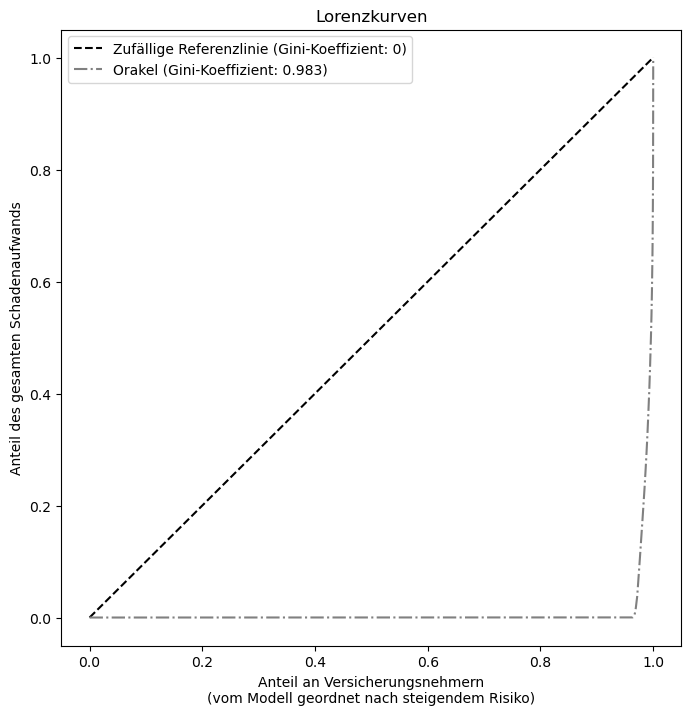

In [21]:
plot_risk_ranking(
    df_train["PurePremium"],
    df_train["Exposure"],
    {},
)

## Modellierung der Schadenhäufigkeit

Die Anzahl der Schäden folgt einem Poissonprozess. Auch die auf die Jahreseinheiten normierte Schadenhäufigkeit folgt einem Poissonprozess und kann entsprechend modelliert werden. Die Jahreseinheiten werden hierbei in der Modellierung als Gewichte verwendet.

### Marginalsummenverfahren

In den üblichen Machine Learning Bibliotheken gibt es keine direkte Implementierung des Marginalsummenverfahrens. Das ist in der Praxis auch nicht zwingend notwendig, da das MSV über ein GLM mit Poisson-Verteilung modelliert werden kann. Der Vollständigkeit halber wird das MSV hier dennoch vorgestellt.

In [22]:
import warnings


class MarginalTotalsRegression:
    """Method of Marignal Totals used for regression.

    This estimator is based on the Method of Marginal Ttotals (MMT) by Bailey (1963).
    See https://www.casact.org/abstract/insurance-rates-minimum-bias for details.

    Parameters
    ----------
    max_iter : int, default=100
        Maximum number of iterations to perform.

    min_factor_change : float, default=0.001
        Minimum change in any factor to continue iterations.

    min_y_change : float, default=0.01
        Minimum change in y to continue iterations.

    baselines : list of int, default=[0]
        List of baseline features per group. The factors are 1 by design.

    verbose : int, default=0
        Controls verbosity of output.

    basevalue_name : list of str, default=["$\gamma_0$"]
        Name of the base value.

    feature_names : list of str, default=None
        Names of features. If None, feature names are set to ["feature_1", "feature_2", ...].

    Attributes
    ----------
    factors_ : ndarray of shape (n_features,)
        The fitted factors.

    factors_change_ : ndarray of shape (n_features,)
        The change in factors between iterations.

    marginal_totals_ : ndarray of shape (n_features,)
        Marginal totals per feature.

    n_iter_ : int
        Number of iterations performed.

    results_ : pd.DataFrame
        Results of the iterations. The first column is the base value. The following columns are the factors.

    total_ : float
        Total sum of y.

    y_change_ : float
        Change in y between iterations.

    y_mean_ : float
        Base value of the model.

    References
    ----------
    .. [1] Bailey, R. A. (1963). Insurance rates by minimum bias. Transactions of the Casualty Actuarial Society, 50, 4ff.


    Examples
    --------
    weights = np.array([300, 700, 600, 200])
    y = np.array([220, 330, 200, 300])
    X = np.array(
        [
            [1.0, 0.0, 0.0, 1.0],
            [1.0, 0.0, 1.0, 0.0],
            [0.0, 1.0, 0.0, 1.0],
            [0.0, 1.0, 1.0, 0.0],
        ]
    )

    mmt = MarginalTotalsRegression()
    mmt.fit(X, y, sample_weight=weights)
    """

    def __init__(
        self,
        max_iter=100,
        min_factor_change=0.001,
        min_y_change=0.001,
        baselines=[0],
        verbose=0,
        basevalue_name="basevalue",
        feature_names=None,
    ):
        self.max_iter = max_iter
        self.min_factor_change = min_factor_change
        self.min_y_change = min_y_change
        self.baselines = baselines if baselines is not None else []
        self.verbose = verbose
        self.basevalue_name = basevalue_name
        self.feature_names = feature_names

    def _get_feature_names(self):
        """Get feature names. If not set, set to default names.

        Returns
        -------
        feature_names : list of str
            Names of features.
        """
        if self.feature_names is None:
            self.feature_names = [
                f"feature_{i}" for i in range(1, self.factors_.shape[0] + 1)
            ]
        return self.feature_names

    def fit(self, X, y, sample_weight=None):
        """Fit the model to data matrix X and target(s) y.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data. The model expects all features to be binary.
            Sparse matrices are not supported.

        y : ndarray of shape (n_samples,)
            Target values.

        sample_weight : ndarray of shape (n_samples,), default=None
            Individual weights for each sample. If None, uniform weights are used.
        """
        if sample_weight is None:
            sample_weight = np.ones(X.shape[0])

        # init factors
        self.factors_ = np.ones(X.shape[1])
        self.updated_factors_ = np.ones(X.shape[1])
        self.factors_change_ = np.zeros(X.shape[1])

        # calculate marginal totals of original data
        self.marginal_totals_ = np.dot(X.T, y * sample_weight)

        # calculate total of original data
        self.total_ = np.sum(y * sample_weight)

        # init mean y
        X_factor = np.multiply(self.factors_, X)
        self.y_mean_ = self.total_ / np.sum(
            np.prod(X_factor, axis=1, where=X_factor > 0) * sample_weight
        )

        # init results
        self.results_ = pd.DataFrame(
            columns=[self.basevalue_name] + self._get_feature_names()
        )

        for i in range(1, self.max_iter + 1):
            self.n_iter_ = i

            # update y mean
            X_factor = np.multiply(self.factors_, X)
            updated_y_mean = self.total_ / np.sum(
                np.prod(X_factor, axis=1, where=X_factor > 0) * sample_weight
            )
            self.y_change_ = np.absolute(self.y_mean_ - updated_y_mean)
            self.y_mean_ = updated_y_mean

            # update factors
            for feature in range(X.shape[1]):
                # except baseline feature of group
                if feature not in self.baselines:
                    col_mask = [
                        True if i != feature else False for i in range(X.shape[1])
                    ]
                    row_mask = X[:, feature] > 0

                    X_factor = np.multiply(
                        self.factors_[col_mask], X[row_mask][:, col_mask]
                    )

                    calc_marginal_total = (
                        np.sum(
                            sample_weight[row_mask]
                            * np.prod(X_factor, axis=1, where=X_factor > 0)
                        )
                        * self.y_mean_
                    )

                    self.updated_factors_[feature] = (
                        self.marginal_totals_[feature] / calc_marginal_total
                    )
                    self.factors_change_[feature] = np.absolute(
                        self.factors_[feature] - self.updated_factors_[feature]
                    )
                    self.factors_[feature] = self.updated_factors_[feature]

            # update results
            self.results_ = pd.concat(
                [
                    self.results_ if not self.results_.empty else None,
                    pd.DataFrame(
                        [np.append(self.y_mean_, self.factors_)],
                        columns=self.results_.columns,
                    ),
                ],
                ignore_index=True,
            )
            if self.verbose > 1:
                print(f"Iteration {i} - y mean: {self.y_mean_}")

            if self.verbose > 2:
                print(
                    f"Iteration {i} - max absolute factor change:"
                    f" {np.max(self.factors_change_)}, y change:"
                    f" {self.y_change_}"
                )

            # Check early stopping criteria after each iteration
            if (
                np.max(self.factors_change_) < self.min_factor_change
                and self.y_change_ < self.min_y_change
            ):
                if self.verbose > 0:
                    print(f"Converged after {self.n_iter_} iterations.")
                break

            if i == self.max_iter:
                warnings.warn(
                    f"Did not converge after {self.max_iter} iterations.", UserWarning
                )

    def predict(self, X):
        """Predict target values for X.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Samples.

        Returns
        -------
        y : ndarray of shape (n_samples,)
            Predicted target values.
        """
        X_factor = np.multiply(self.factors_, X)
        return np.prod(X_factor, axis=1, where=X_factor != 0) * self.y_mean_

Der Einfachheit halber verwenden wir das erste Merkmal in jeder Gruppe als Referenzkategorie. In einem realen Szenario würden wir die Referenzkategorie mit einer Heuristik wählen.

Achtung! Die obige Implementierung ist sehr langsam. Es dauert ~ 320 Iterationen und ~ 30 Minuten, um zu konvergieren. Sie können diesen Teil überspringen, indem Sie `run_mmt = False` in der untenstehenden Zelle setzen. Die Ergebnisse für das MSV können der Thesis entnommen werden.

In [23]:
run_mmt = False

In [24]:
if run_mmt:
    mmt = MarginalTotalsRegression(
        max_iter=1000,
        baselines=[0, 10, 20, 31, 43, 45, 67, 73, 82],
        feature_names=feature_names_mmt,
    )
    mmt.fit(X_train_mmt, df_train["Frequency"], sample_weight=df_train["Exposure"])

    scores_mmt = score_estimator(
        mmt,
        X_train_mmt,
        X_test_mmt,
        df_train,
        df_test,
        target="Frequency",
        weights="Exposure",
    )

    scores_mmt

Basiswert und Faktoren in den letzten Iterationen.

In [25]:
if run_mmt:
    mmt.results_.tail()

### Generalisierte Lineare Modelle

Glücklicherweise sind wir nicht an die obige, langsame Implementierung des MSV gebunden. Die Faktoren, die sich aus dem MSV ergebenen, können auch aus einem [Poisson GLM abgeleitet](https://www.cambridge.org/core/journals/astin-bulletin-journal-of-the-iaa/article/on-automobile-insurance-ratemaking/8986C8F3B46597B172F2FCAFCC170B2C) werden. Hierbei ist es wichtig, dass das Poisson GLM mit Interzept und ohne Regularisierung trainiert wird. Zur Durchführung dieser Transformation nutzen wir die folgende Hilfsklasse. Diese kann unabhängig der Zielvariablen für die Transformation von Koeffizienten und Interzept in Faktoren verwendet werden.

In [26]:
class AdditiveToMultiplicativeModel:
    """Convert an additive model to a multiplicative model.

    Parameters
    ----------
    model : object
        Additive model to convert. Must have a `coef_` and `intercept_` attribute.

    baselines : list of int, default=None
        List of baseline features, that are taken as reference categories. There should
        be one baseline feature per category. The factors are 1 by design.

    category_splits : list of int, default=None
        List of indices to split `coef_` into categories.

    Attributes
    ----------
    factors_ : ndarray of shape (n_features,)
        The fitted factors.

    y_mean_ : float
        Base value of the model.

    Examples
    --------
    from sklearn.linear_model import PoissonRegressor

    model = PoissonRegressor(alpha=0, fit_intercept=True)

    amm = AdditiveToMultiplicativeModel(model)
    amm.fit(X_train, y_train)

    amm.predict(X_test)
    """

    def __init__(self, model, baselines=None, category_splits=None):
        self.model = model
        self.baselines = baselines
        self.category_splits = category_splits if category_splits is not None else []

    def fit(self, X, y, sample_weight=None):
        """AdditiveToMultiplicativeModel fit.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data.

        y : ndarray of shape (n_samples,)
            Target values.

        sample_weight : ndarray of shape (n_samples,), default=None
            Individual weights for each sample. If None, uniform weights are used.
        """
        if sample_weight is None:
            sample_weight = np.ones(X.shape[0])

        self.model.fit(X, y, sample_weight=sample_weight)

        if self.baselines is None:
            self.factors_ = np.exp(self.model.coef_)
            self.y_mean_ = np.exp(self.model.intercept_)
        else:
            categories = np.split(self.model.coef_, self.category_splits)
            for category, baseline in zip(range(len(categories)), self.baselines):
                categories[category] = np.exp(
                    categories[category] - self.model.coef_[baseline]
                )
            self.factors_ = np.concatenate(categories)
            self.y_mean_ = np.exp(
                self.model.intercept_ + np.sum(self.model.coef_[self.baselines])
            )

    def predict(self, X):
        """Predict target values for X.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Samples.

        Returns
        -------

        y : ndarray of shape (n_samples,)
            Predicted target values.
        """
        X_factor = np.multiply(self.factors_, X)
        return np.prod(X_factor, axis=1, where=X_factor > 0) * self.y_mean_

Für Poisson GLMs können wir die Implementierung aus der scikit-learn Bibliothek verwenden. Interzept und Koeffizienten können dann einfach in die MSV-Faktoren umgewandelt werden.

In [27]:
from sklearn.linear_model import PoissonRegressor

glm_poisson_multiplicative = AdditiveToMultiplicativeModel(
    PoissonRegressor(alpha=0, max_iter=1000, fit_intercept=True),
    baselines=[0, 10, 20, 31, 43, 45, 67, 73, 82],
    category_splits=[10, 20, 31, 43, 45, 67, 73, 82],
)
glm_poisson_multiplicative.fit(
    X_train_mmt, df_train["Frequency"], sample_weight=df_train["Exposure"]
)

score_glm_poisson_multiplicative = score_estimator(
    glm_poisson_multiplicative,
    X_train_mmt,
    X_test_mmt,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)

score_glm_poisson_multiplicative

subset,train,test
metric,,
D² explained,0.0493,0.0466
mean Poisson dev,0.4550,0.4543
mean abs. error,0.1375,0.1373
mean squared error,0.2437,0.2235


Alternativ kann man auch ein Poisson GLM trainieren, ohne dass die Koeffizienten in MMT-Faktoren umgewandelt werden müssen. Dies bietet zum einem die Möglichkeit, numerische Merkmale direkt zu verwenden und zum anderen die Möglichkeit, Regularisierung zu verwenden. Das folgende Modell macht von beiden Möglichkeiten Gebrauch.

In [28]:
from sklearn.linear_model import PoissonRegressor

glm_poisson_freq = PoissonRegressor(alpha=1e-4, solver="newton-cholesky")
glm_poisson_freq.fit(
    X_train_glm, df_train["Frequency"], sample_weight=df_train["Exposure"]
)

scores_glm_poisson_freq = score_estimator(
    glm_poisson_freq,
    X_train_glm,
    X_test_glm,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)

scores_glm_poisson_freq

subset,train,test
metric,,
D² explained,0.0448,0.0427
mean Poisson dev,0.4572,0.4561
mean abs. error,0.1379,0.1378
mean squared error,0.2441,0.2246


### Gradient Boosting Modelle

Im nächsten Abschnitt trainieren wir ein Gradient Boosting Modell mit einer Poisson Verlustfunktion.

#### Hyperparameter Optimierung

Gradient Boosting funktioniert für diese Modellierungsaufgabe nicht sehr gut mit den Standard Hyperparametern. Die Hyperparameter müssen üblicherweise optimiert werden. Wir nehmen die folgenden Hyperparameter als gegeben an.

In [29]:
best_params_xgb_poisson = {
    "alpha": 1.994140493625288,
    "colsample_bytree": 0.6340734410360876,
    "lambda": 0.008013593648196619,
    "learning_rate": 0.022071505695314412,
    "max_depth": 7,
    "min_child_weight": 145,
    "subsample": 0.9302303532384276,
}
boost_rounds_poisson = 945

In [30]:
import xgboost as xgb

xgb_poisson_freq = xgb.XGBRegressor(
    objective="count:poisson",
    tree_method="hist",
    device="cuda",
    n_estimators=boost_rounds_poisson,
    n_jobs=-1,
    **best_params_xgb_poisson,
)

xgb_poisson_freq.fit(
    X_train_xgb, df_train["Frequency"], sample_weight=df_train["Exposure"]
)

scores_xgb_poisson_freq = score_estimator(
    xgb_poisson_freq,
    X_train_xgb,
    X_test_xgb,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)

scores_xgb_poisson_freq

/home/fabian/miniforge3/envs/fremtpl/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:28:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650282415/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


subset,train,test
metric,,
D² explained,0.0849,0.0644
mean Poisson dev,0.4379,0.4458
mean abs. error,0.1355,0.1361
mean squared error,0.2414,0.2224


### Vorhersagekraft Schadenhäufigkeit

Wir haben bereits beim Training der obigen Modelle vereinzelt die Scores sehen können. Im Folgenden betrachten wir die Ergebnisse der Vorhersagemetriken gesamtheitlich.

In [31]:
if run_mmt:
    scores = pd.concat(
        [
            scores_mmt,
            score_glm_poisson_multiplicative,
            scores_glm_poisson_freq,
            scores_xgb_poisson_freq,
        ],
        axis=1,
        sort=True,
        keys=(
            "Marginalsummenverfahren",
            "GLM Poisson Multiplikativ",
            "GLM Poisson",
            "XGBoost Poisson",
        ),
    )

else:
    scores = pd.concat(
        [
            score_glm_poisson_multiplicative,
            scores_glm_poisson_freq,
            scores_xgb_poisson_freq,
        ],
        axis=1,
        sort=True,
        keys=("GLM Poisson Multiplikativ", "GLM Poisson", "XGBoost Poisson"),
    )

Trainingsdaten

In [32]:
scores.T.loc[(slice(None), "train"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Poisson dev,mean abs. error,mean squared error
GLM Poisson Multiplikativ,0.0493,0.4550,0.1375,0.2437
GLM Poisson,0.0448,0.4572,0.1379,0.2441
XGBoost Poisson,0.0849,0.4379,0.1355,0.2414


In [33]:
# scores.T.loc[(slice(None), "train"), :].droplevel(1).rename_axis(None, axis=1).to_latex(
#     buf="/home/fabian/Projects/master-thesis/thesis/Tables/scores_frequency_train.tex",
#     float_format="%.4f",
#     multicolumn_format="c",
#     na_rep="",
#     header=["$D^2$", "$D_P$", "$MAE$", "$MSE$"],
# )

Testdaten

In [34]:
scores.T.loc[(slice(None), "test"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Poisson dev,mean abs. error,mean squared error
GLM Poisson Multiplikativ,0.0466,0.4543,0.1373,0.2235
GLM Poisson,0.0427,0.4561,0.1378,0.2246
XGBoost Poisson,0.0644,0.4458,0.1361,0.2224


In [35]:
# scores.T.loc[(slice(None), "test"), :].droplevel(1).rename_axis(None, axis=1).to_latex(
#     buf="/home/fabian/Projects/master-thesis/thesis/Tables/scores_frequency_test.tex",
#     float_format="%.4f",
#     multicolumn_format="c",
#     na_rep="",
#     header=["$D^2$", "$D_P$", "$MAE$", "$MSE$"],
# )

### Gesamtzahl der Schäden

In [36]:
if run_mmt:
    train_index = [
        "Trainingsdaten",
        "Marginalsummenverfahren",
        "GLM Poisson Multiplikativ",
        "GLM Poisson",
        "XGBoost Poisson",
    ]
    test_index = [
        "Testdaten",
        "Marginalsummenverfahren",
        "GLM Poisson Multiplikativ",
        "GLM Poisson",
        "XGBoost Poisson",
    ]
    train_mean_freq = [
        np.average(df_train["Frequency"], weights=df_train["Exposure"]),
        np.average(mmt.predict(X_train_mmt), weights=df_train["Exposure"]),
        np.average(
            glm_poisson_multiplicative.predict(X_train_mmt),
            weights=df_train["Exposure"],
        ),
        np.average(glm_poisson_freq.predict(X_train_glm), weights=df_train["Exposure"]),
        np.average(xgb_poisson_freq.predict(X_train_xgb), weights=df_train["Exposure"]),
    ]
    test_mean_freq = [
        np.average(df_test["Frequency"], weights=df_test["Exposure"]),
        np.average(mmt.predict(X_test_mmt), weights=df_test["Exposure"]),
        np.average(
            glm_poisson_multiplicative.predict(X_test_mmt), weights=df_test["Exposure"]
        ),
        np.average(glm_poisson_freq.predict(X_test_glm), weights=df_test["Exposure"]),
        np.average(xgb_poisson_freq.predict(X_test_xgb), weights=df_test["Exposure"]),
    ]
    train_ClaimNb = [
        df_train["ClaimNb"].sum(),
        (mmt.predict(X_train_mmt) * df_train["Exposure"]).sum(),
        (glm_poisson_multiplicative.predict(X_train_mmt) * df_train["Exposure"]).sum(),
        (glm_poisson_freq.predict(X_train_glm) * df_train["Exposure"]).sum(),
        (xgb_poisson_freq.predict(X_train_xgb) * df_train["Exposure"]).sum(),
    ]
    test_ClaimNb = [
        df_test["ClaimNb"].sum(),
        (mmt.predict(X_test_mmt) * df_test["Exposure"]).sum(),
        (glm_poisson_multiplicative.predict(X_test_mmt) * df_test["Exposure"]).sum(),
        (glm_poisson_freq.predict(X_test_glm) * df_test["Exposure"]).sum(),
        (xgb_poisson_freq.predict(X_test_xgb) * df_test["Exposure"]).sum(),
    ]
else:
    train_index = [
        "Trainingsdaten",
        "GLM Poisson Multiplikativ",
        "GLM Poisson",
        "XGBoost Poisson",
    ]
    test_index = [
        "Testdaten",
        "GLM Poisson Multiplikativ",
        "GLM Poisson",
        "XGBoost Poisson",
    ]
    train_mean_freq = [
        np.average(df_train["Frequency"], weights=df_train["Exposure"]),
        np.average(
            glm_poisson_multiplicative.predict(X_train_mmt),
            weights=df_train["Exposure"],
        ),
        np.average(glm_poisson_freq.predict(X_train_glm), weights=df_train["Exposure"]),
        np.average(xgb_poisson_freq.predict(X_train_xgb), weights=df_train["Exposure"]),
    ]
    test_mean_freq = [
        np.average(df_test["Frequency"], weights=df_test["Exposure"]),
        np.average(
            glm_poisson_multiplicative.predict(X_test_mmt), weights=df_test["Exposure"]
        ),
        np.average(glm_poisson_freq.predict(X_test_glm), weights=df_test["Exposure"]),
        np.average(xgb_poisson_freq.predict(X_test_xgb), weights=df_test["Exposure"]),
    ]
    train_ClaimNb = [
        df_train["ClaimNb"].sum(),
        (glm_poisson_multiplicative.predict(X_train_mmt) * df_train["Exposure"]).sum(),
        (glm_poisson_freq.predict(X_train_glm) * df_train["Exposure"]).sum(),
        (xgb_poisson_freq.predict(X_train_xgb) * df_train["Exposure"]).sum(),
    ]
    test_ClaimNb = [
        df_test["ClaimNb"].sum(),
        (glm_poisson_multiplicative.predict(X_test_mmt) * df_test["Exposure"]).sum(),
        (glm_poisson_freq.predict(X_test_glm) * df_test["Exposure"]).sum(),
        (xgb_poisson_freq.predict(X_test_xgb) * df_test["Exposure"]).sum(),
    ]

train_freq_summary = pd.DataFrame(
    {
        "Mittlere Häufigkeit": train_mean_freq,
        "Anzahl Schadenfälle": [int(ClaimNb) for ClaimNb in train_ClaimNb],
    },
    index=train_index,
)
test_freq_summary = pd.DataFrame(
    {
        "Mittlere Häufigkeit": test_mean_freq,
        "Anzahl Schadenfälle": [int(ClaimNb) for ClaimNb in test_ClaimNb],
    },
    index=test_index,
)

In [37]:
train_freq_summary

,Mittlere Häufigkeit,Anzahl Schadenfälle
Trainingsdaten,0.073724,19800
GLM Poisson Multiplikativ,0.073716,19797
GLM Poisson,0.073724,19800
XGBoost Poisson,0.073732,19801


In [38]:
# train_freq_summary.to_latex(
#     buf="/home/fabian/Projects/master-thesis/thesis/Tables/freq_summary_train.tex",
#     float_format="%.4f",
#     multicolumn_format="c",
#     na_rep="",
# )

In [39]:
test_freq_summary

,Mittlere Häufigkeit,Anzahl Schadenfälle
Testdaten,0.073570,6606
GLM Poisson Multiplikativ,0.073809,6627
GLM Poisson,0.073890,6634
XGBoost Poisson,0.073780,6624


In [40]:
# test_freq_summary.to_latex(
#     buf="/home/fabian/Projects/master-thesis/thesis/Tables/freq_summary_test.tex",
#     float_format="%.4f",
#     multicolumn_format="c",
#     na_rep="",
# )

In [41]:
if run_mmt:
    model_predictions = {
        "GLM Poisson Multiplikativ": glm_poisson_multiplicative.predict(X_test_mmt),
        "GLM Poisson": glm_poisson_freq.predict(X_test_glm),
        "XGBoost Poisson": xgb_poisson_freq.predict(X_test_xgb),
        "Marginalsummenverfahren": mmt.predict(X_test_mmt),
    }
else:
    model_predictions = {
        "GLM Poisson Multiplikativ": glm_poisson_multiplicative.predict(X_test_mmt),
        "GLM Poisson": glm_poisson_freq.predict(X_test_glm),
        "XGBoost Poisson": xgb_poisson_freq.predict(X_test_xgb),
    }

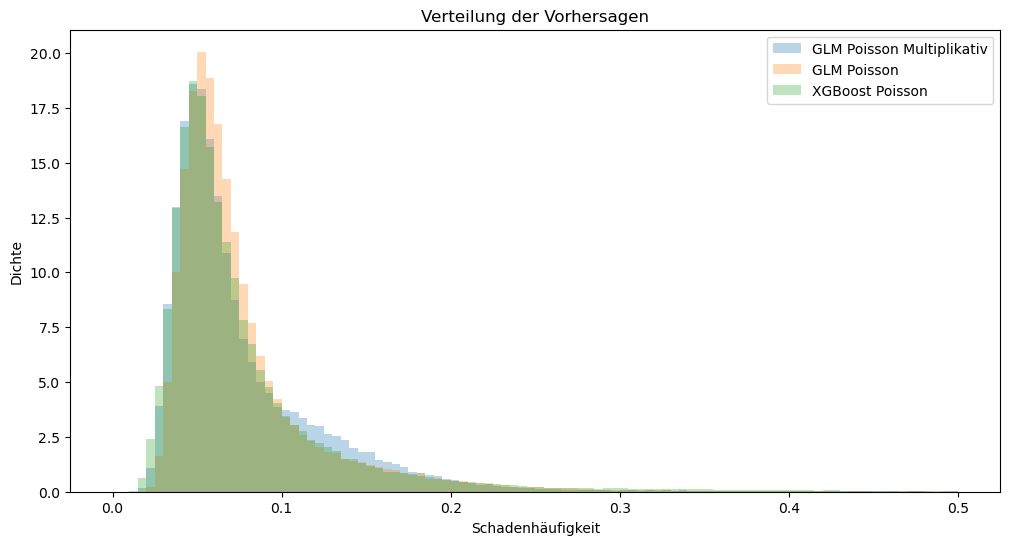

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

for label, y_pred in model_predictions.items():
    ax.hist(
        y_pred,
        bins=100,
        density=True,
        alpha=0.3,
        label=label,
        range=(0, 0.5),
    )

ax.set(
    title="Verteilung der Vorhersagen",
    xlabel="Schadenhäufigkeit",
    ylabel="Dichte",
)
ax.legend(loc="upper right")

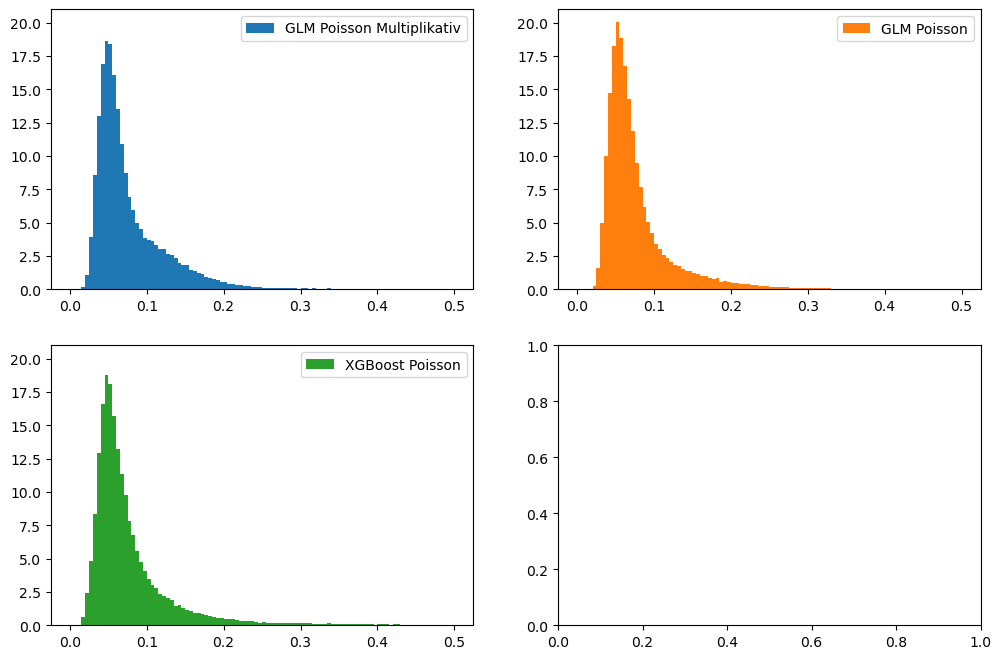

In [43]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for (label, y_pred), color, ax in zip(model_predictions.items(), colors, axs.flatten()):
    ax.hist(
        y_pred,
        bins=100,
        density=True,
        color=color,
        label=label,
        range=(0, 0.5),
    )
    ax.legend(loc="upper right")
    ax.set_ylim(0, 21)

#### Risikodifferenzierung

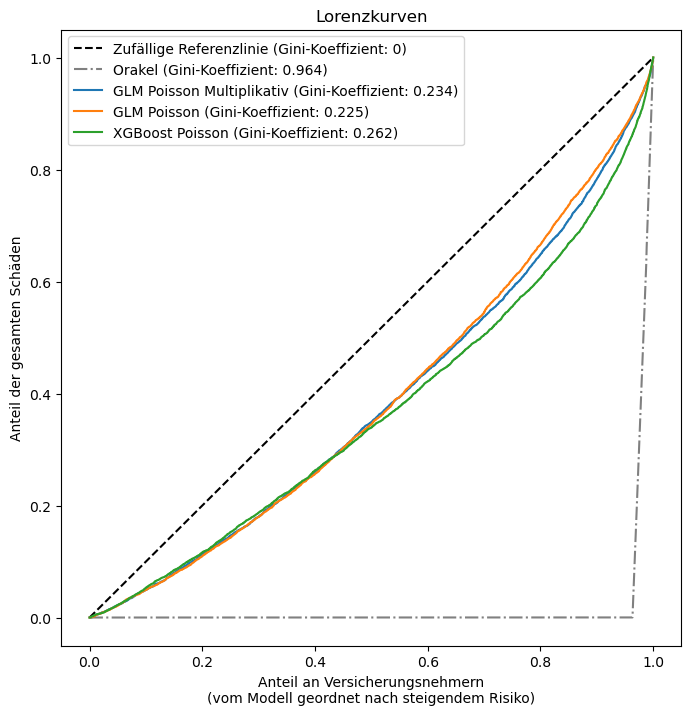

In [44]:
if run_mmt:
    plot_risk_ranking(
        df_test["Frequency"],
        df_test["Exposure"],
        {
            "GLM Poisson Multiplikativ": glm_poisson_multiplicative.predict(X_test_mmt),
            "GLM Poisson": glm_poisson_freq.predict(X_test_glm),
            "XGBoost Poisson": xgb_poisson_freq.predict(X_test_xgb),
            "Marginalsummenverfahren": mmt.predict(X_test_mmt),
        },
        ylabel="Anteil der gesamten Schäden",
    )

else:
    plot_risk_ranking(
        df_test["Frequency"],
        df_test["Exposure"],
        {
            "GLM Poisson Multiplikativ": glm_poisson_multiplicative.predict(X_test_mmt),
            "GLM Poisson": glm_poisson_freq.predict(X_test_glm),
            "XGBoost Poisson": xgb_poisson_freq.predict(X_test_xgb),
        },
        ylabel="Anteil der gesamten Schäden",
    )

## Modellierung der Schadenhöhe

Für die Modellierung kommen in der Theorie verschiedene rechtsschiefe, stets positive Verteilungen für die Schadenhöhe in Frage. In der Praxis hat sich die Gammaverteilung bewährt.

Beachte:
- Wir nutzen die obigen Filtermasken, um die Schäden $(-\infty, 0]$ herauszufiltern.
- Die Anzahl der Schäden wird als Geweicht in der Modellierung verwendet.
- Aus Performancegründen betrachten wir nur das multiplikative Poisson GLM, auf eine erneute Anwendung des MSV wird verzichtet.

### Generalsierte Lineare Modelle

Wir nutzen hierbei eine Gamma GLM in seiner nativen Form und transformiert in ein multiplikatives Modell.

In [45]:
from sklearn.linear_model import GammaRegressor

glm_gamma_sev = GammaRegressor(alpha=10.0, solver="newton-cholesky")
glm_gamma_sev.fit(
    X_train_glm[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

glm_gamma_multiplicative = AdditiveToMultiplicativeModel(
    GammaRegressor(alpha=10, max_iter=1000),
    baselines=[0, 10, 20, 31, 43, 45, 67, 73, 82],
    category_splits=[10, 20, 31, 43, 45, 67, 73, 82],
)
glm_gamma_multiplicative.fit(
    X_train_mmt[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores_glm_gamma_sev = score_estimator(
    glm_gamma_sev,
    X_train_glm[mask_train.values],
    X_test_glm[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)

scores_glm_gamma_multiplicative = score_estimator(
    glm_gamma_multiplicative,
    X_train_mmt[mask_train.values],
    X_test_mmt[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)

display(scores_glm_gamma_sev)
display(scores_glm_gamma_multiplicative)

subset,train,test
metric,,
D² explained,3.900000e-03,4.400000e-03
mean Gamma dev,1.435100e+00,1.394700e+00
mean abs. error,1.756746e+03,1.744042e+03
mean squared error,5.801770e+07,5.030677e+07


subset,train,test
metric,,
D² explained,1.000000e-03,5.000000e-04
mean Gamma dev,1.439300e+00,1.400200e+00
mean abs. error,1.755518e+03,1.743285e+03
mean squared error,5.803309e+07,5.033476e+07


### Gradient Boosting Modelle

Analog zur Modellierung der Schadenhäufigkeit nutzen wir eine GBM mit Gamma Verlustfunktion. Die Hyperparameter nehmen wir wieder als geben an.

In [46]:
best_params_xgb_gamma = {
    "alpha": 0.6399765728900835,
    "colsample_bytree": 0.30104790017247346,
    "lambda": 0.0012592046178894732,
    "learning_rate": 0.07456133834046624,
    "max_depth": 3,
    "min_child_weight": 281,
    "subsample": 0.6532237673584566,
}
boost_rounds_gamma = 141

GBMs sind nicht parametrisierte Modelle. D.h. sie treffen keine Annahme über die Verteilung der Zielvariablen. Daher kann es bei unsymmetrischen Verlustfunktionen passieren, dass das 1. Moment der Verteilung der Zielvariablen, nicht dem 1. Moment der Vorhersage entspricht. Im Konktext der Schadenhöhe ist das ein Problem. Eine massive Über- oder Unterschätzung des Durchschnittsschadens kann zu Problemen in der Kundenaquise oder massivem Verlust für den Versicherer führen. Entsprechend kann es notwendig sein, dass man das Niveau nach der Baumbildung noch einmal kallibriert. Hierzu wird der folgende Wrapper genutzt.

In [47]:
class CalibratedRegressor:
    """Wrapper to calibrate the output of a regression estimator based
    on the training data.

    Parameters
    ----------
    estimator : estimator
        The trained estimator object.
    X : array-like of shape (n_samples, n_features)
        The training data.
    y : array-like of shape (n_samples,)
        The target values.
    weights : array-like of shape (n_samples,), default=None
        Individual weights for each sample. If None, uniform weights are used.
    """

    def __init__(self, estimator, X, y, weights=None):
        self.estimator = estimator
        self.X = X
        self.y = y
        self.weights = weights if weights is not None else np.ones(X.shape[0])
        self.factor = self._get_factor()

    def _get_factor(self):
        """Compute the factor for calibration.

        The factor for calibration is the ratio of the sum of the target
        variable to the sum of the predictions of the regression estimator on
        the training data.
        """
        y_sum = np.sum(self.y * self.weights)
        predt = np.sum(self.estimator.predict(self.X) * self.weights)
        return y_sum / predt

    def predict(self, X, **kwargs):
        """Predict using the calibrated regression estimator.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples.
        **kwargs : dict
            Additional keyword arguments are passed to the predict method of the
            estimator.

        Returns
        -------
        y : ndarray of shape (n_samples,)
            The predicted values.
        """

        return self.estimator.predict(X, **kwargs) * self.factor

In [48]:
xgb_gamma_sev = xgb.XGBRegressor(
    objective="reg:gamma",
    tree_method="hist",
    device="cuda",
    n_estimators=boost_rounds_gamma,
    n_jobs=-1,
    **best_params_xgb_gamma,
)

xgb_gamma_sev.fit(
    X_train_xgb[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

xgb_gamma_sev_calibrated = CalibratedRegressor(
    xgb_gamma_sev,
    X_train_xgb[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    weights=df_train.loc[mask_train, "ClaimNb"],
)

scores_xgb_gamma_sev = score_estimator(
    xgb_gamma_sev,
    X_train_xgb[mask_train.values],
    X_test_xgb[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)

scores_xgb_gamma_sev_calibrated = score_estimator(
    xgb_gamma_sev_calibrated,
    X_train_xgb[mask_train.values],
    X_test_xgb[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)

display(scores_xgb_gamma_sev)
display(scores_xgb_gamma_sev_calibrated)

subset,train,test
metric,,
D² explained,4.640000e-02,8.800000e-03
mean Gamma dev,1.373900e+00,1.388600e+00
mean abs. error,1.683039e+03,1.670748e+03
mean squared error,5.773907e+07,5.027763e+07


subset,train,test
metric,,
D² explained,4.630000e-02,1.030000e-02
mean Gamma dev,1.374100e+00,1.386500e+00
mean abs. error,1.749944e+03,1.739230e+03
mean squared error,5.771594e+07,5.026899e+07


Die Schadenhöhe ist eine sehr schwierige Modellierungsaufgabe, so dass die Scores der Metriken nicht sonderlich überwältigen. Daher macht es Sinn, hier zusätzlich ein Dummy-Modell, das konstant den Mittelwert vorhersagt, als Referenz zu betrachten.

In [49]:
from sklearn.dummy import DummyRegressor

dummy_sev = DummyRegressor(strategy="mean")
dummy_sev.fit(
    X_train_glm[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores_dummy = score_estimator(
    dummy_sev,
    X_train_glm[mask_train.values],
    X_test_glm[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)

scores_dummy

subset,train,test
metric,,
D² explained,0.000000e+00,-0.000000e+00
mean Gamma dev,1.440800e+00,1.400900e+00
mean abs. error,1.756687e+03,1.744497e+03
mean squared error,5.803882e+07,5.033764e+07


### Vorhersagekraft der Schadenhöhe

In [50]:
scores = pd.concat(
    [
        scores_glm_gamma_sev,
        scores_glm_gamma_multiplicative,
        scores_xgb_gamma_sev,
        scores_xgb_gamma_sev_calibrated,
        scores_dummy,
    ],
    axis=1,
    sort=True,
    keys=(
        "GLM Gamma",
        "GLM Gamma Multiplikativ",
        "XGBoost Gamma",
        "XGBoost Gamma kalibriert",
        "Dummy",
    ),
)

In [51]:
scores.T.loc[(slice(None), "train"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Gamma dev,mean abs. error,mean squared error
GLM Gamma,0.0039,1.4351,1756.7459,5.801770e+07
GLM Gamma Multiplikativ,0.0010,1.4393,1755.5178,5.803309e+07
XGBoost Gamma,0.0464,1.3739,1683.0390,5.773907e+07
XGBoost Gamma kalibriert,0.0463,1.3741,1749.9435,5.771594e+07
Dummy,0.0000,1.4408,1756.6873,5.803882e+07


In [52]:
# scores.T.loc[(slice(None), "train"), :].droplevel(1).rename_axis(None, axis=1).to_latex(
#     buf="/home/fabian/Projects/master-thesis/thesis/Tables/scores_severity_train.tex",
#     # float_format="%.4f",
#     formatters=[
#         "{:.4f}".format,
#         "{:.4f}".format,
#         "{:.0f}".format,
#         "{:.3E}".format,
#     ],
#     multicolumn_format="c",
#     na_rep="",
#     header=["$D^2$", "$D_G$", "$MAE$", "$MSE$"],
# )

In [53]:
scores.T.loc[(slice(None), "test"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Gamma dev,mean abs. error,mean squared error
GLM Gamma,0.0044,1.3947,1744.0418,5.030677e+07
GLM Gamma Multiplikativ,0.0005,1.4002,1743.2855,5.033476e+07
XGBoost Gamma,0.0088,1.3886,1670.7478,5.027763e+07
XGBoost Gamma kalibriert,0.0103,1.3865,1739.2299,5.026899e+07
Dummy,-0.0000,1.4009,1744.4968,5.033764e+07


In [54]:
# scores.T.loc[(slice(None), "test"), :].droplevel(1).rename_axis(None, axis=1).to_latex(
#     buf="/home/fabian/Projects/master-thesis/thesis/Tables/scores_severity_test.tex",
#        formatters=[
#         "{:.4f}".format,
#         "{:.4f}".format,
#         "{:.0f}".format,
#         "{:.3E}".format,
#     ],
#     multicolumn_format="c",
#     na_rep="",
#     header=["$D^2$", "$D_G$", "$MAE$", "$MSE$"],
# )

### Gesamt- und Durchschnittsschaden

In [55]:
train_index = [
    "Trainingsdaten",
    "GLM Gamma",
    "GLM Gamma Multiplikativ",
    "XGBoost Gamma",
    "XGBoost Gamma kalibriert",
    "DummyRegressor",
]

test_index = [
    "Testdaten",
    "GLM Gamma",
    "GLM Gamma Multiplikativ",
    "XGBoost Gamma",
    "XGBoost Gamma kalibriert",
    "DummyRegressor",
]

train_mean_sev = [
    df_train.loc[mask_train, "AvgClaimAmount"].mean(),
    glm_gamma_sev.predict(X_train_glm).mean(),
    glm_gamma_multiplicative.predict(X_train_mmt).mean(),
    xgb_gamma_sev.predict(X_train_xgb).mean(),
    xgb_gamma_sev_calibrated.predict(X_train_xgb).mean(),
    dummy_sev.predict(X_train_glm).mean(),
]

test_mean_sev = [
    df_test.loc[mask_test, "AvgClaimAmount"].mean(),
    glm_gamma_sev.predict(X_test_glm).mean(),
    glm_gamma_multiplicative.predict(X_test_mmt).mean(),
    xgb_gamma_sev.predict(X_test_xgb).mean(),
    xgb_gamma_sev_calibrated.predict(X_test_xgb).mean(),
    dummy_sev.predict(X_test_glm).mean(),
]

train_ClaimAmount = [
    df_train["ClaimAmount"].sum(),
    (glm_gamma_sev.predict(X_train_glm) * df_train["ClaimNb"]).sum(),
    (glm_gamma_multiplicative.predict(X_train_mmt) * df_train["ClaimNb"]).sum(),
    (xgb_gamma_sev.predict(X_train_xgb) * df_train["ClaimNb"]).sum(),
    (xgb_gamma_sev_calibrated.predict(X_train_xgb) * df_train["ClaimNb"]).sum(),
    (dummy_sev.predict(X_train_glm) * df_train["ClaimNb"]).sum(),
]

test_ClaimAmount = [
    df_test["ClaimAmount"].sum(),
    (glm_gamma_sev.predict(X_test_glm) * df_test["ClaimNb"]).sum(),
    (glm_gamma_multiplicative.predict(X_test_mmt) * df_test["ClaimNb"]).sum(),
    (xgb_gamma_sev.predict(X_test_xgb) * df_test["ClaimNb"]).sum(),
    (xgb_gamma_sev_calibrated.predict(X_test_xgb) * df_test["ClaimNb"]).sum(),
    (dummy_sev.predict(X_test_glm) * df_test["ClaimNb"]).sum(),
]

train_min_sev = [
    df_train.loc[mask_train, "AvgClaimAmount"].min(),
    glm_gamma_sev.predict(X_train_glm).min(),
    glm_gamma_multiplicative.predict(X_train_mmt).min(),
    xgb_gamma_sev.predict(X_train_xgb).min(),
    xgb_gamma_sev_calibrated.predict(X_train_xgb).min(),
    dummy_sev.predict(X_train_glm).min(),
]

test_min_sev = [
    df_test.loc[mask_test, "AvgClaimAmount"].min(),
    glm_gamma_sev.predict(X_test_glm).min(),
    glm_gamma_multiplicative.predict(X_test_mmt).min(),
    xgb_gamma_sev.predict(X_test_xgb).min(),
    xgb_gamma_sev_calibrated.predict(X_test_xgb).min(),
    dummy_sev.predict(X_test_glm).min(),
]

train_max_sev = [
    df_train.loc[mask_train, "AvgClaimAmount"].max(),
    glm_gamma_sev.predict(X_train_glm).max(),
    glm_gamma_multiplicative.predict(X_train_mmt).max(),
    xgb_gamma_sev.predict(X_train_xgb).max(),
    xgb_gamma_sev_calibrated.predict(X_train_xgb).max(),
    dummy_sev.predict(X_train_glm).max(),
]

test_max_sev = [
    df_test.loc[mask_test, "AvgClaimAmount"].max(),
    glm_gamma_sev.predict(X_test_glm).max(),
    glm_gamma_multiplicative.predict(X_test_mmt).max(),
    xgb_gamma_sev.predict(X_test_xgb).max(),
    xgb_gamma_sev_calibrated.predict(X_test_xgb).max(),
    dummy_sev.predict(X_test_glm).max(),
]

train_sev_summary = pd.DataFrame(
    {
        "Mittlerer Schadenhöhe": train_mean_sev,
        "Gesamte Schadenhöhe": train_ClaimAmount,
        "Minimale Schadenhöhe": train_min_sev,
        "Maximale Schadenhöhe": train_max_sev,
    },
    index=train_index,
)

test_sev_summary = pd.DataFrame(
    {
        "Mittlerer Schadenhöhe": test_mean_sev,
        "Gesamte Schadenhöhe": test_ClaimAmount,
        "Minimale Schadenhöhe": test_min_sev,
        "Maximale Schadenhöhe": test_max_sev,
    },
    index=test_index,
)

In [56]:
train_sev_summary

,Mittlerer Schadenhöhe,Gesamte Schadenhöhe,Minimale Schadenhöhe,Maximale Schadenhöhe
Trainingsdaten,1951.209522,3.917618e+07,1.000000,200000.000000
GLM Gamma,1940.946696,3.915529e+07,1849.768720,3371.625147
GLM Gamma Multiplikativ,1976.438476,3.914687e+07,1953.151061,2003.999926
XGBoost Gamma,1865.106445,3.722511e+07,1100.803467,3599.080322
XGBoost Gamma kalibriert,1962.861572,3.917618e+07,1158.499634,3787.718018
DummyRegressor,1978.594850,3.917618e+07,1978.594850,1978.594850


In [57]:
# train_sev_summary.to_latex(
#     buf="/home/fabian/Projects/master-thesis/thesis/Tables/sev_summary_train.tex",
#     formatters=[
#         "{:.0f}".format,
#         "{:.3E}".format,
#         "{:.0f}".format,
#         "{:.0f}".format,
#     ],
#     multicolumn_format="c",
#     na_rep="",
#     header=[
#         "Mittelwert",
#         "Gesamt",
#         "Min",
#         "Max",
#     ],
# )

In [58]:
test_sev_summary

,Mittlerer Schadenhöhe,Gesamte Schadenhöhe,Minimale Schadenhöhe,Maximale Schadenhöhe
Testdaten,1927.976907,1.299546e+07,1.490000,200000.000000
GLM Gamma,1940.701088,1.306552e+07,1849.922470,3389.341044
GLM Gamma Multiplikativ,1976.421931,1.306042e+07,1954.137289,2003.491999
XGBoost Gamma,1864.413452,1.240900e+07,1135.186890,3494.851562
XGBoost Gamma kalibriert,1962.132568,1.305939e+07,1194.685181,3678.026367
DummyRegressor,1978.594850,1.307060e+07,1978.594850,1978.594850


In [59]:
# test_sev_summary.to_latex(
#     buf="/home/fabian/Projects/master-thesis/thesis/Tables/sev_summary_test.tex",
#     formatters=[
#         "{:.0f}".format,
#         "{:.3E}".format,
#         "{:.0f}".format,
#         "{:.0f}".format,
#     ],
#     multicolumn_format="c",
#     na_rep="",
#     header=[
#         "Mittelwert",
#         "Gesamt",
#         "Min",
#         "Max",
#     ],
# )

In [60]:
model_predictions = {
    "GLM Gamma": glm_gamma_sev.predict(X_test_glm),
    "GLM Gamma Multiplikativ": glm_gamma_multiplicative.predict(X_test_mmt),
    "XGBoost Gamma": xgb_gamma_sev.predict(X_test_xgb),
    "XGBoost Gamma kalibriert": xgb_gamma_sev_calibrated.predict(X_test_xgb),
}

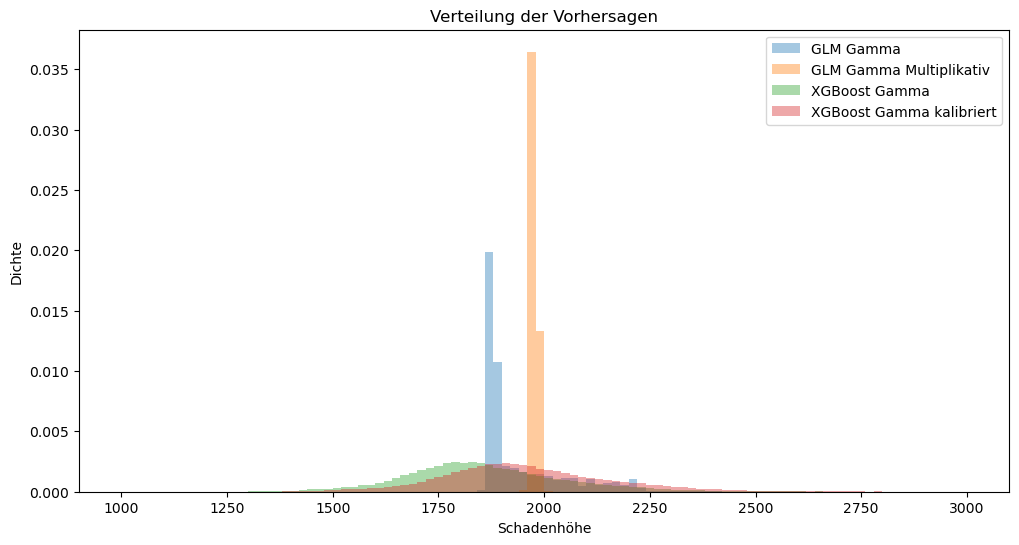

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))

for label, y_pred in model_predictions.items():
    ax.hist(
        y_pred,
        bins=100,
        density=True,
        alpha=0.4,
        label=label,
        range=(1000, 3000),
    )

ax.set(
    title="Verteilung der Vorhersagen",
    xlabel="Schadenhöhe",
    ylabel="Dichte",
)
ax.legend(loc="upper right")

# fig.savefig("/home/fabian/Projects/master-thesis/thesis/Figures/dist_sev_predictions.png")

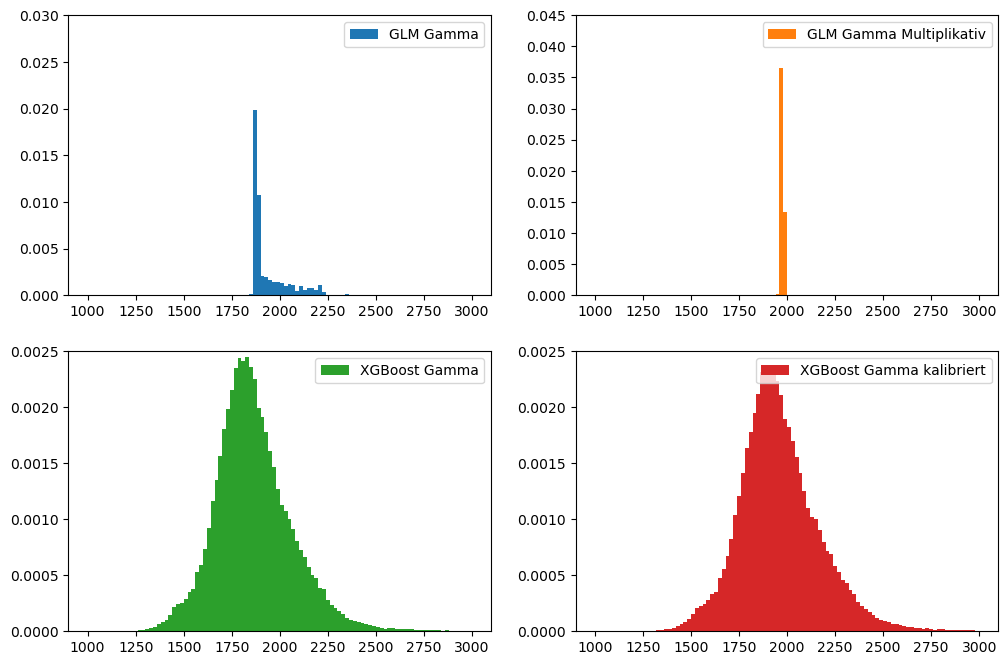

In [62]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
ylims = [0.03, 0.045, 0.0025, 0.0025]

for (label, y_pred), color, ax, ylim in zip(
    model_predictions.items(), colors, axs.flatten(), ylims
):
    ax.hist(
        y_pred,
        bins=100,
        density=True,
        color=color,
        label=label,
        range=(1000, 3000),
    )
    ax.legend(loc="upper right")
    ax.set_ylim(0, ylim)

### Risikodifferenzierung

Da sich die Kalibrierung der GBM nur auf das Niveau auswirkt, genügt die Darstellung eines der beiden Modelle, da sie vollständig überlappen.

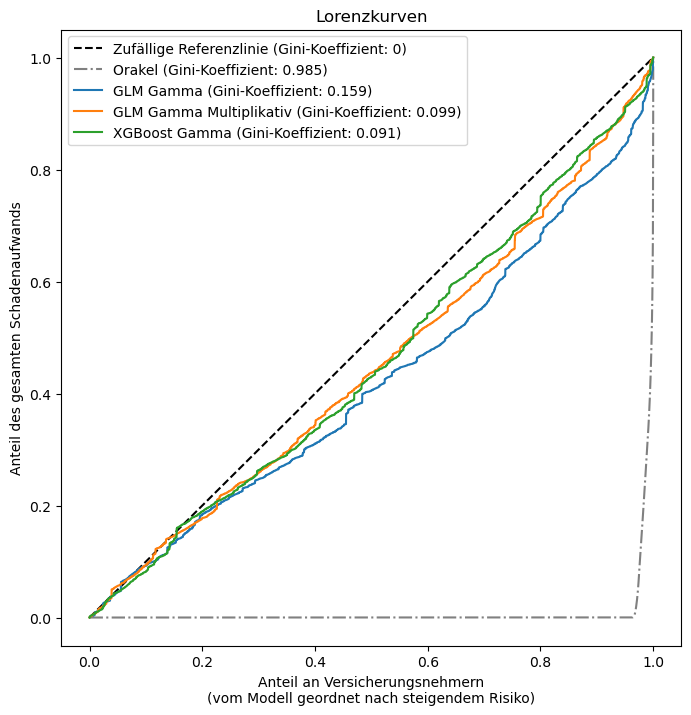

In [63]:
plot_risk_ranking(
    df_test["AvgClaimAmount"],
    df_test["ClaimNb"],
    {
        "GLM Gamma": glm_gamma_sev.predict(X_test_glm),
        "GLM Gamma Multiplikativ": glm_gamma_multiplicative.predict(X_test_mmt),
        "XGBoost Gamma": xgb_gamma_sev.predict(X_test_xgb),
    },
    # plot="/home/fabian/Projects/master-thesis/thesis/Figures/lorenz_curve_severity.png",
)

## Modellierung der Nettorisikoprämie

### Direkte Modellierung

#### Generalisierte Lineare Modelle

Für die direkte Modellierung der Nettorisikoprämie eignen sich GLMs auf Basis der Tweedie Familie mit einem Exponentialparameter $1<p<2$. Je näher der Parameter bei 1 liegt, desto mehr ähnelt die Verteilung einer Poisson Verteilung. Für Werte nahe der 2, nähert man sich der Gamma Verteilung an.

Die Praxis zeigt, dass obwohl es sich bei der Poisson Verteilung um eine diskrete Verteilung handelt, man auch mittels Poisson GLMs gute Ergebnisse für die Nettorisikoprämie erzielen kann. Wir betrachten im Folgenden Poisson und Tweedie GLMs. Auf die Transformation in multiplikative Modelle wird der übersichtlichkeit halber verzichtet. Diese ist analog den Modellierungen für die Schadenhäufigkeit und -höhe möglich. Für den Exponentialparameter nehmen für das Modelltraining den Wert 1.9 an. In einem realen Szenario sollte man hier über die Behandlung als Hyperparameter oder geschäftspolitische Entscheidung nachdenken.

In [64]:
from sklearn.linear_model import TweedieRegressor

glm_tweedie_pure = TweedieRegressor(power=1.9, alpha=0.1, solver="newton-cholesky")
glm_tweedie_pure.fit(
    X_train_glm, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

glm_poisson_pure = PoissonRegressor(alpha=0.1, solver="newton-cholesky")
glm_poisson_pure.fit(
    X_train_glm, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_glm_tweedie_pure = score_estimator(
    glm_tweedie_pure,
    X_train_glm,
    X_test_glm,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores_glm_poisson_pure = score_estimator(
    glm_poisson_pure,
    X_train_glm,
    X_test_glm,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)


scores = pd.concat(
    [
        scores_glm_tweedie_pure,
        scores_glm_poisson_pure,
    ],
    axis=1,
    sort=True,
    keys=(
        "GLM Tweedie",
        "GLM Poisson",
    ),
)

In [65]:
scores.T.loc[(slice(None), "train"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
GLM Tweedie,0.0164,76.4077,36.8288,30.3760,33.8212,201.5347,1914.5380,19047.4703,273.9865,3.295505e+07
GLM Poisson,0.0168,76.1431,36.7659,30.3472,33.8091,201.5299,1914.5337,19047.4660,273.3377,3.294714e+07


In [66]:
scores.T.loc[(slice(None), "test"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
GLM Tweedie,0.0137,76.4088,36.9227,30.4539,33.8783,201.5587,1914.3868,19045.5807,273.1249,3.213056e+07
GLM Poisson,0.0142,76.2371,36.8694,30.4237,33.8611,201.5482,1914.3768,19045.5708,272.5738,3.211700e+07


#### Gradient Boosting Modelle

In [67]:
best_params_xgb_tweedie = {
    "alpha": 0.028072221800410555,
    "colsample_bytree": 0.7468053850541801,
    "lambda": 1.4601095085621913,
    "learning_rate": 0.02732393009139623,
    "max_depth": 3,
    "min_child_weight": 177,
    "subsample": 0.6413275834237984,
}
boost_rounds_tweedie = 281

In [68]:
xgb_tweedie_pure = xgb.XGBRegressor(
    objective="reg:tweedie",
    tweedie_variance_power=1.9,
    tree_method="hist",
    device="cuda",
    n_estimators=boost_rounds_tweedie,
    n_jobs=-1,
    **best_params_xgb_tweedie,
)

xgb_tweedie_pure.fit(
    X_train_xgb, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

xgb_tweedie_pure_calibrated = CalibratedRegressor(
    xgb_tweedie_pure,
    X_train_xgb,
    df_train["PurePremium"],
    weights=df_train["Exposure"],
)


score_xgb_tweedie_pure = score_estimator(
    xgb_tweedie_pure,
    X_train_xgb,
    X_test_xgb,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

score_xgb_tweedie_pure_calibrated = score_estimator(
    xgb_tweedie_pure_calibrated,
    X_train_xgb,
    X_test_xgb,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [
        score_xgb_tweedie_pure,
        score_xgb_tweedie_pure_calibrated,
    ],
    axis=1,
    sort=True,
    keys=(
        "XGB Tweedie",
        "XGB Tweedie Kalibriert",
    ),
)

In [69]:
scores.T.loc[(slice(None), "train"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
XGB Tweedie,0.0243,74.3993,36.1011,29.9335,33.5504,201.3598,1914.3704,19047.3041,258.9600,3.294002e+07
XGB Tweedie Kalibriert,0.0239,74.3910,36.1186,29.9504,33.5645,201.3710,1914.3813,19047.3150,273.5062,3.293848e+07


In [70]:
scores.T.loc[(slice(None), "test"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
XGB Tweedie,0.0160,75.8406,36.7134,30.3264,33.8004,201.5086,1914.3387,19045.5335,257.8162,3.211121e+07
XGB Tweedie Kalibriert,0.0164,75.7436,36.6799,30.3062,33.7881,201.5006,1914.3310,19045.5259,272.3598,3.211026e+07


### Frequency-Severity Modellierung

Für die Frequency-Severity Modellierung betrachten wir drei Kombinationen

- GLM Poisson * GLM Gamma
- XGB Poisson * XGB Gamma (kalibriert)
- XGB Poisson * GLM Gamma 

In [71]:
scores_glm_product = score_estimator(
    (glm_poisson_freq, glm_gamma_sev),
    (X_train_glm, X_train_glm),
    (X_test_glm, X_test_glm),
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores_xgb_product = score_estimator(
    (xgb_poisson_freq, xgb_gamma_sev_calibrated),
    (X_train_xgb, X_train_xgb),
    (X_test_xgb, X_test_xgb),
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores_xgb_glm_product = score_estimator(
    (xgb_poisson_freq, glm_gamma_sev),
    (X_train_xgb, X_train_glm),
    (X_test_xgb, X_test_glm),
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [
        scores_glm_product,
        scores_xgb_product,
        scores_xgb_glm_product,
    ],
    axis=1,
    sort=True,
    keys=("GLM Produkt", "XGB Produkt", "XGB/GLM Produkt"),
)

In [72]:
scores.T.loc[(slice(None), "train"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
GLM Produkt,0.0148,76.6993,36.9574,30.4601,33.8758,201.5716,1914.5735,19047.5057,273.0119,3.295040e+07
XGB Produkt,0.0274,73.3240,35.7610,29.7420,33.4426,201.2956,1914.3094,19047.2434,269.0106,3.293048e+07
XGB/GLM Produkt,0.0249,73.9908,36.0000,29.8863,33.5301,201.3516,1914.3631,19047.2962,268.4550,3.293475e+07


In [73]:
scores.T.loc[(slice(None), "test"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
GLM Produkt,0.0146,76.1705,36.8398,30.4053,33.8500,201.5414,1914.3703,19045.5644,272.2128,3.212197e+07
XGB Produkt,0.0194,74.6854,36.3462,30.1191,33.6835,201.4389,1914.2725,19045.4676,269.2882,3.210152e+07
XGB/GLM Produkt,0.0189,74.7662,36.3817,30.1428,33.6994,201.4501,1914.2834,19045.4779,268.7088,3.210232e+07


### Vorhersagekraft der Nettorisikoprämie

In [74]:
scores = pd.concat(
    [
        scores_glm_tweedie_pure,
        scores_glm_poisson_pure,
        score_xgb_tweedie_pure,
        score_xgb_tweedie_pure_calibrated,
        scores_glm_product,
        scores_xgb_product,
        scores_xgb_glm_product,
    ],
    axis=1,
    sort=True,
    keys=(
        "GLM Tweedie",
        "GLM Poisson",
        "XGB Tweedie",
        "XGB Tweedie Kalibriert",
        "GLM Produkt",
        "XGB Produkt",
        "XGB/GLM Produkt",
    ),
)

In [75]:
scores.T.loc[(slice(None), "train"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
GLM Tweedie,0.0164,76.4077,36.8288,30.3760,33.8212,201.5347,1914.5380,19047.4703,273.9865,3.295505e+07
GLM Poisson,0.0168,76.1431,36.7659,30.3472,33.8091,201.5299,1914.5337,19047.4660,273.3377,3.294714e+07
XGB Tweedie,0.0243,74.3993,36.1011,29.9335,33.5504,201.3598,1914.3704,19047.3041,258.9600,3.294002e+07
XGB Tweedie Kalibriert,0.0239,74.3910,36.1186,29.9504,33.5645,201.3710,1914.3813,19047.3150,273.5062,3.293848e+07
GLM Produkt,0.0148,76.6993,36.9574,30.4601,33.8758,201.5716,1914.5735,19047.5057,273.0119,3.295040e+07
XGB Produkt,0.0274,73.3240,35.7610,29.7420,33.4426,201.2956,1914.3094,19047.2434,269.0106,3.293048e+07
XGB/GLM Produkt,0.0249,73.9908,36.0000,29.8863,33.5301,201.3516,1914.3631,19047.2962,268.4550,3.293475e+07


In [76]:
scores.T.loc[(slice(None), "test"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Tweedie dev p=1.5000,mean Tweedie dev p=1.7000,mean Tweedie dev p=1.8000,mean Tweedie dev p=1.9000,mean Tweedie dev p=1.9900,mean Tweedie dev p=1.9990,mean Tweedie dev p=1.9999,mean abs. error,mean squared error
GLM Tweedie,0.0137,76.4088,36.9227,30.4539,33.8783,201.5587,1914.3868,19045.5807,273.1249,3.213056e+07
GLM Poisson,0.0142,76.2371,36.8694,30.4237,33.8611,201.5482,1914.3768,19045.5708,272.5738,3.211700e+07
XGB Tweedie,0.0160,75.8406,36.7134,30.3264,33.8004,201.5086,1914.3387,19045.5335,257.8162,3.211121e+07
XGB Tweedie Kalibriert,0.0164,75.7436,36.6799,30.3062,33.7881,201.5006,1914.3310,19045.5259,272.3598,3.211026e+07
GLM Produkt,0.0146,76.1705,36.8398,30.4053,33.8500,201.5414,1914.3703,19045.5644,272.2128,3.212197e+07
XGB Produkt,0.0194,74.6854,36.3462,30.1191,33.6835,201.4389,1914.2725,19045.4676,269.2882,3.210152e+07
XGB/GLM Produkt,0.0189,74.7662,36.3817,30.1428,33.6994,201.4501,1914.2834,19045.4779,268.7088,3.210232e+07


### Gesamtschaden

In [77]:
train_index = [
    "Trainingsdaten",
    "GLM Tweedie",
    "GLM Poisson",
    "XGB Tweedie",
    "XGB Tweedie Kalibriert",
    "GLM Produkt",
    "XGB Produkt",
    "XGB/GLM Produkt",
]

test_index = [
    "Testdaten",
    "GLM Tweedie",
    "GLM Poisson",
    "XGB Tweedie",
    "XGB Tweedie Kalibriert",
    "GLM Produkt",
    "XGB Produkt",
    "XGB/GLM Produkt",
]

train_ClaimAmt = [
    df_train["ClaimAmount"].sum(),
    (glm_tweedie_pure.predict(X_train_glm) * df_train["Exposure"]).sum(),
    (glm_poisson_pure.predict(X_train_glm) * df_train["Exposure"]).sum(),
    (xgb_tweedie_pure.predict(X_train_xgb) * df_train["Exposure"]).sum(),
    (xgb_tweedie_pure_calibrated.predict(X_train_xgb) * df_train["Exposure"]).sum(),
    (
        glm_poisson_freq.predict(X_train_glm)
        * glm_gamma_sev.predict(X_train_glm)
        * df_train["Exposure"]
    ).sum(),
    (
        xgb_poisson_freq.predict(X_train_xgb)
        * xgb_gamma_sev_calibrated.predict(X_train_xgb)
        * df_train["Exposure"]
    ).sum(),
    (
        xgb_poisson_freq.predict(X_train_xgb)
        * glm_gamma_sev.predict(X_train_glm)
        * df_train["Exposure"]
    ).sum(),
]

test_ClaimAmt = [
    df_test["ClaimAmount"].sum(),
    (glm_tweedie_pure.predict(X_test_glm) * df_test["Exposure"]).sum(),
    (glm_poisson_pure.predict(X_test_glm) * df_test["Exposure"]).sum(),
    (xgb_tweedie_pure.predict(X_test_xgb) * df_test["Exposure"]).sum(),
    (xgb_tweedie_pure_calibrated.predict(X_test_xgb) * df_test["Exposure"]).sum(),
    (
        glm_poisson_freq.predict(X_test_glm)
        * glm_gamma_sev.predict(X_test_glm)
        * df_test["Exposure"]
    ).sum(),
    (
        xgb_poisson_freq.predict(X_test_xgb)
        * xgb_gamma_sev_calibrated.predict(X_test_xgb)
        * df_test["Exposure"]
    ).sum(),
    (
        xgb_poisson_freq.predict(X_test_xgb)
        * glm_gamma_sev.predict(X_test_glm)
        * df_test["Exposure"]
    ).sum(),
]

train_pure_summary = pd.DataFrame(
    {
        "Gesamtschaden": train_ClaimAmt,
    },
    index=train_index,
)

test_pure_summary = pd.DataFrame(
    {
        "Gesamtschaden": test_ClaimAmt,
    },
    index=test_index,
)

In [78]:
train_pure_summary

,Gesamtschaden
Trainingsdaten,3.917618e+07
GLM Tweedie,3.951751e+07
GLM Poisson,3.917618e+07
XGB Tweedie,3.473469e+07
XGB Tweedie Kalibriert,3.917618e+07
GLM Produkt,3.916555e+07
XGB Produkt,3.917680e+07
XGB/GLM Produkt,3.914267e+07


In [79]:
test_pure_summary

,Gesamtschaden
Testdaten,1.299546e+07
GLM Tweedie,1.325198e+07
GLM Poisson,1.314235e+07
XGB Tweedie,1.160785e+07
XGB Tweedie Kalibriert,1.309213e+07
GLM Produkt,1.313276e+07
XGB Produkt,1.310247e+07
XGB/GLM Produkt,1.309162e+07


In [80]:
model_predictions = {
    "GLM Tweedie": glm_tweedie_pure.predict(X_test_glm),
    "GLM Poisson": glm_poisson_pure.predict(X_test_glm),
    "XGB Tweedie Kalibriert": xgb_tweedie_pure_calibrated.predict(X_test_xgb),
    "GLM Produkt": glm_poisson_freq.predict(X_test_glm) * glm_gamma_sev.predict(
        X_test_glm
    ),
    "XGB Produkt": xgb_poisson_freq.predict(
        X_test_xgb
    ) * xgb_gamma_sev_calibrated.predict(X_test_xgb),
    "XGB/GLM Produkt": xgb_poisson_freq.predict(X_test_xgb) * glm_gamma_sev.predict(
        X_test_glm
    ),
}

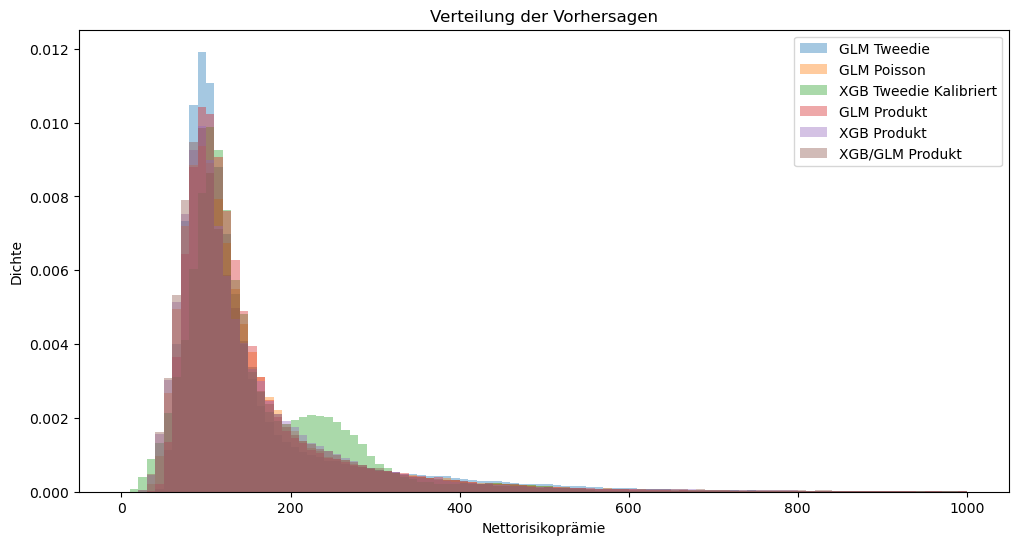

In [81]:
fig, ax = plt.subplots(figsize=(12, 6))

for label, y_pred in model_predictions.items():
    ax.hist(
        y_pred,
        bins=100,
        density=True,
        alpha=0.4,
        label=label,
        range=(0, 1000),
    )

ax.set(
    title="Verteilung der Vorhersagen",
    xlabel="Nettorisikoprämie",
    ylabel="Dichte",
)

ax.legend(loc="upper right")

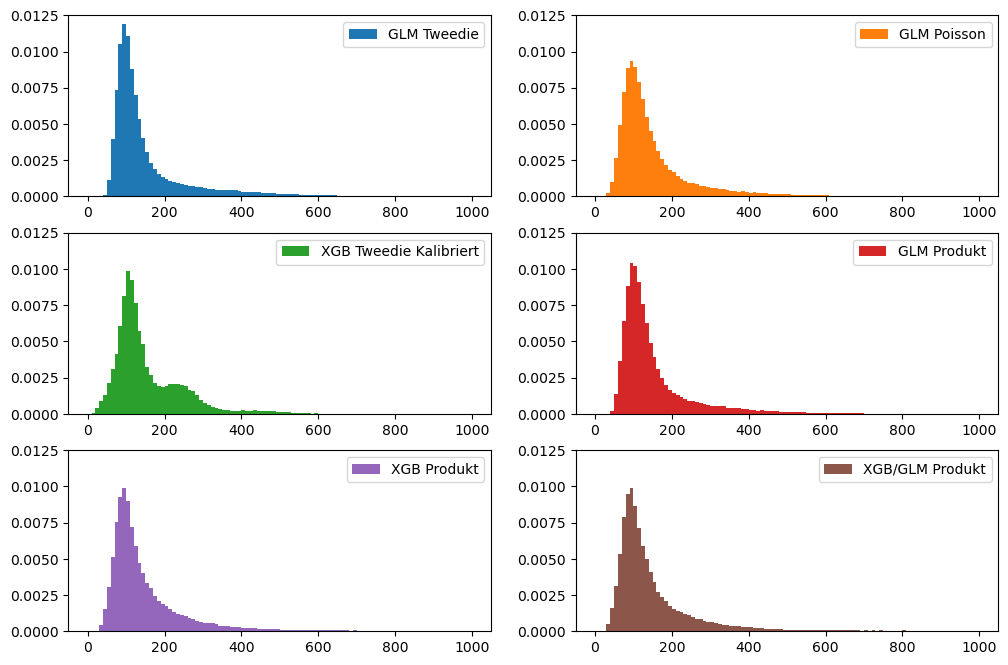

In [82]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(12, 8))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for (label, y_pred), color, ax in zip(model_predictions.items(), colors, axs.flatten()):
    ax.hist(
        y_pred,
        bins=100,
        density=True,
        color=color,
        label=label,
        range=(0, 1000),
    )
    ax.legend(loc="upper right")
    ax.set_ylim(0, 0.0125)

### Risikodifferenzierung

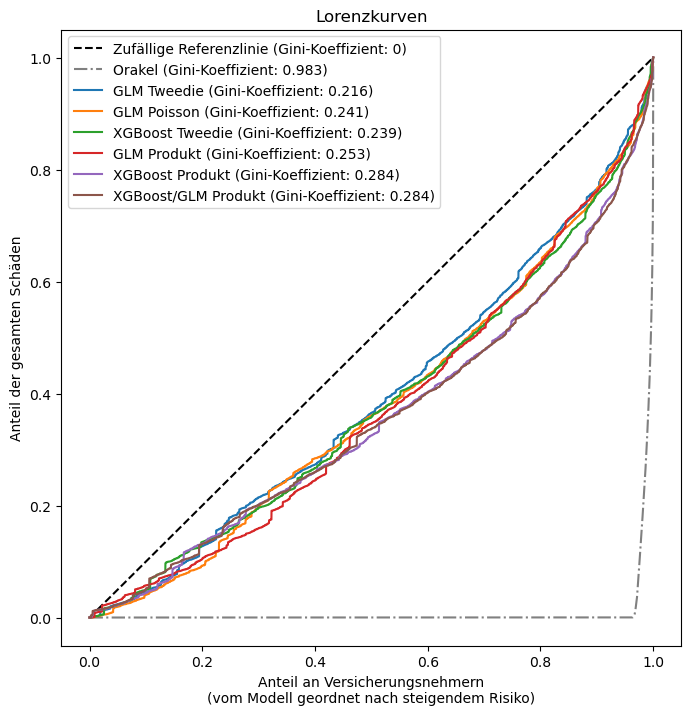

In [83]:
plot_risk_ranking(
    df_test["PurePremium"],
    df_test["Exposure"],
    {
        "GLM Tweedie": glm_tweedie_pure.predict(X_test_glm),
        "GLM Poisson": glm_poisson_pure.predict(X_test_glm),
        "XGBoost Tweedie": xgb_tweedie_pure.predict(X_test_xgb),
        "GLM Produkt": glm_poisson_freq.predict(X_test_glm) * glm_gamma_sev.predict(
            X_test_glm
        ),
        "XGBoost Produkt": xgb_poisson_freq.predict(
            X_test_xgb
        ) * xgb_gamma_sev_calibrated.predict(X_test_xgb),
        "XGBoost/GLM Produkt": xgb_poisson_freq.predict(
            X_test_xgb
        ) * glm_gamma_sev.predict(X_test_glm),
    },
    ylabel="Anteil der gesamten Schäden",
)

## Erklärbarkeit der Modelle

### Statistische Inferenz für GLMS

Statistische Inferenz ist die Standardmethode in der Risikomodellierung, um die Einfüsse der Tarifmerkmale im GLM zu erklären. Dieser Methodik ist leider nicht auf Gradient Boosting Modelle übertragbar und auch nicht in den Standard Machine Learning Bibliotheken* implmentiert. Der Fokus liegt in diesen Bibliotheken eher auf der Vorhersagekraft, als auf der statistischen Infenz der exogenen Variablen.

Der Vollständigkeit halber betrachten wir im Folgenden die Implementierung für ein Poisson GLM mit der log-likelihood Funktion:

$$
L(\beta) = \sum_{i=1}^n y_i \cdot \beta^T x_i - exp(\beta^T x_i) 
$$

Mit der Anzahl an Observationen $n$, $y_i$ der $i$-ten Ausprägung der Zielvariablen, $x_i$ der $i$-ten Zeile der Designmatrix und den Koeffiienten $\beta$.

Die Hesse Matrix der log-likelihood Funktion:

$$
H(\beta) = \sum_{i=1}^n -exp(\beta^T x_i) \cdot x_i x_i^T
$$

Daraus ergibt sich Varianz-Kovarianz-Matrix:

$$
V(\beta) = (-H)^{-1}
$$

\* Es gibt durchaus jedoch andere Bibliotheken mit statistischem Fokus. Ein Beispiel ist [statsmodels](https://www.statsmodels.org/stable/index.html). Diesen fehlen dafür andere für das Machine Learning übliche Funktionen.

In [84]:
def variance_covariance_matrix(X, params, weights=None):
    """Calculate the variance-covariance matrix of a model.

    Parameters
    ----------
    X : numpy.ndarray
        The input data.
    params : numpy.ndarray
        The parameters of the model.

    Returns
    -------
    numpy.ndarray
        The variance-covariance matrix.
    """
    if weights is None:
        weights = np.ones(X.shape[0])

    y_hat = np.exp(X.dot(params))
    hessian = -np.dot(X.T * y_hat, weights[:, None] * X)
    return np.linalg.inv(-hessian)

Auf Basis der Varianz-Kovarianz-Matrix lässt sich dann der Standard-Fehler der Koeefizienten $SE(\beta)$ errechnen:

$$
SE(\beta) = \sqrt{diag(V(\beta))}
$$

In [85]:
def standard_error(cov):
    """Calculate the standard error of parameter estimates.

    Parameters
    ----------
    cov : numpy.ndarray
        The variance-covariance matrix.

    Returns
    -------
    numpy.ndarray
        The standard error.
    """
    return np.sqrt(np.diagonal(cov))

Nun können aus den Koeffizienten $\beta$ und den dazugehörigen Standard-Fehlern $SE(\beta)$ die z-Werte errechnet werden:

$$
z = \frac{\beta}{SE(\beta)}
$$

In [86]:
def z_value(params, se):
    """Calculate the z-value of parameter estimates.

    Parameters
    ----------
    params : numpy.ndarray
        The parameters of the model.
    se : numpy.ndarray
        The standard error of the parameter estimates.

    Returns
    -------
    numpy.ndarray
        The z-value.
    """
    return params / se

Auf Basis der z-Werte und der Anzahl an Freiheitsgraden lässt sich dann der p-Wert errechnen:

$$
p = 2 \cdot (1 - \Phi(|z|))
$$

mit $\Phi$ der kumulativen Verteilungsfunktion der t-Verteilung.

In [87]:
from scipy import stats


def calc_p_value(z_value, df):
    """Calculate the p-value of parameter estimates.

    Parameters
    ----------
    z_value : numpy.ndarray
        The z-value of the parameter estimates.
    df : int
        The degrees of freedom.

    Returns
    -------
    numpy.ndarray
        The p-value.
    """
    return (1 - stats.t.cdf(np.abs(z_value), df)) * 2

Hierzu lassen sich dann auch die Konfidenzintervalle für die Koeffizienten errechnen:

$$
CI = \beta \pm z_{1-\alpha/2} \cdot SE(\beta)
$$


In [88]:
def calc_confidence_intervalls(params, se, df, alpha=0.05):
    """Calculate the confidence intervals of parameter estimates.

    Parameters
    ----------
    params : numpy.ndarray
        The parameters of the model.
    se : numpy.ndarray
        The standard error of the parameter estimates.
    df : int
        The degrees of freedom.
    alpha : float
        The significance level.

    Returns
    -------
    numpy.ndarray
        The confidence intervals.
    """
    return (
        params + stats.t.ppf(alpha / 2, df) * se,
        params + stats.t.ppf(1 - alpha / 2, df) * se,
    )

In [89]:
def regression_summary(X, params, weights=None, feature_names=None, alpha=0.05):
    """Prints a summary of the regression results.

    Parameters
    ----------
    X : numpy.ndarray
        The input data.
    params : numpy.ndarray
        The parameters of the model.
    feature_names : list
        The names of the features.
    alpha : float
        The significance level.
    """
    df = X.shape[0] - X.shape[1]
    cov = variance_covariance_matrix(X, params, weights=weights)
    se = standard_error(cov)
    z = z_value(params, se)
    p = calc_p_value(z, df)
    ci = calc_confidence_intervalls(params, se, df, alpha)

    if feature_names is None:
        feature_names = [f"f_{i}" for i in range(X.shape[1])]
    else:
        feature_names = feature_names

    return pd.DataFrame(
        {
            "coef": params,
            "std err": se,
            "z": z,
            "P>|z|": p,
            f"[{alpha/2}": ci[0],
            f"{1-alpha/2}]": ci[1],
        },
        index=feature_names,
    )

Zur Berechnung dieser Werte sind jedoch einige Nebenbedingungen zu erfüllen. 

- Das Modell muss ohne Regularisierung trainiert worden sein.
- Die Features müssen unkorreliert sein.

Die oben gezeigten Modelle und Trainingsdaten erfüllen diese Bedingungen nicht. Die GLMs wurden mit Regularisierung trainiert und die Features sind korreliert. Daher wird exemplarisch ein kleines Modell ohne Regularisierung nur mit den beiden Features "BonusMalus" und "Density" trainiert.

In [90]:
features = ["BonusMalus", "Density_log"]

In [91]:
glm_poisson_freq_stat = PoissonRegressor(
    alpha=0, max_iter=1000, fit_intercept=True, solver="newton-cholesky"
)
glm_poisson_freq_stat.fit(
    X_train_glm[features], df_train["Frequency"], sample_weight=df_train["Exposure"]
)

PoissonRegressor(alpha=0, max_iter=1000, solver='newton-cholesky')

In [92]:
regression_summary(
    X=np.append(
        X_train_glm[features].values,
        np.ones(X_train_glm[features].shape[0]).reshape(-1, 1),
        axis=1,
    ),
    params=np.append(glm_poisson_freq_stat.coef_, glm_poisson_freq_stat.intercept_),
    weights=df_train["Exposure"].values,
    feature_names=features + ["Intercept"],
    alpha=0.05,
)

,coef,std err,z,P>|z|,[0.025,0.975]
BonusMalus,0.023752,0.000349,68.002521,0.0,0.023067,0.024436
Density_log,0.143362,0.007177,19.974767,0.0,0.129295,0.157429
Intercept,-4.059830,0.023772,-170.781029,0.0,-4.106423,-4.013238


### SHAP

SHAP (SHapley Additive exPlanations) ist eine Methode, die auf der Spieltheorie basiert und die Einflüsse der Merkmale zur Vorhersage erklärt. SHAP ist eine modell-agnostische Methode und kann auf alle Modelle angewendet werden. Mittels der SHAP-Methode kann sowohl die Makro- als auch die Mikroerklärbarkeit der Modelle untersucht werden.

In [93]:
import shap

np.random.seed(42)

#### SHAP für GLMs

Wir betrachten zunächst die Generalisierten Linearen Modelle. Hierfür gibt es im SHAP-Paket eine spezielle Implementierung, die die spezielle Struktur der GLMs ausnutzt. Wir starten mit der Makroebebene.

Beachte: Binder stellt nur eine begrenzte Menge an Resourcen zur Verfügung. Daher wird die Anzahl der betrachteten Samples hier limitiert. Stehen auf einer anderen Machine mehr Resourcen zur Verfügung, dann kann die n_samples Variable erhöht werden.

In [94]:
n_samples = 1000
X_train_glm_sample = X_train_glm.sample(n_samples, random_state=42)

glm_tweedie_pure_exp = shap.Explainer(
    glm_tweedie_pure,
    X_train_glm_sample,
)

glm_tweedie_pure_exp = glm_tweedie_pure_exp(X_train_glm_sample)

glm_tweedie_pure_exp = shap.Explanation(
    values=glm_tweedie_pure_exp.values,
    base_values=glm_tweedie_pure_exp.base_values,
    data=glm_tweedie_pure_exp.data,
    feature_names=feature_names_glm,
    display_data=glm_tweedie_pure_exp.data,
)

Um einen generellen Überblick über die Einflüsse der Merkmale zu erhalten, betrachten wir zunächst die relative Stärke der Einflüsse der Merkmale. Der Übersichtlichkeit halber werden nur die 10 stärksten Einflüsse dargestellt.

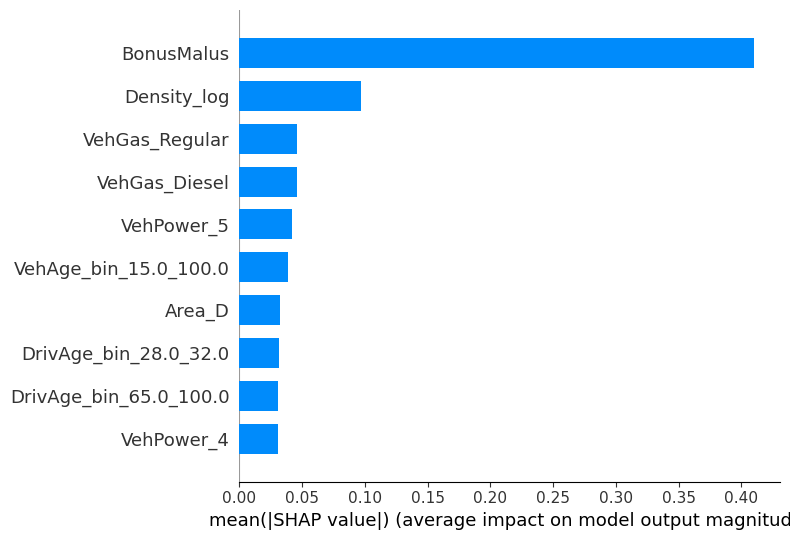

In [95]:
shap.summary_plot(
    glm_tweedie_pure_exp,
    max_display=10,
    plot_type="bar",
)

Um die Richtung der Einflüsse besser verstehen zu können, gibt es auch eine Merkmalswert abhängige Darstellung. Für jedes Merkmal wird der Wert des Merkmals farbig dargestellt und gemäß der Stärke und Richtung des Einflusses einsortiert. Häufigkeiten bestimmter Ausprägungen werden ebenfalls sichtbar.

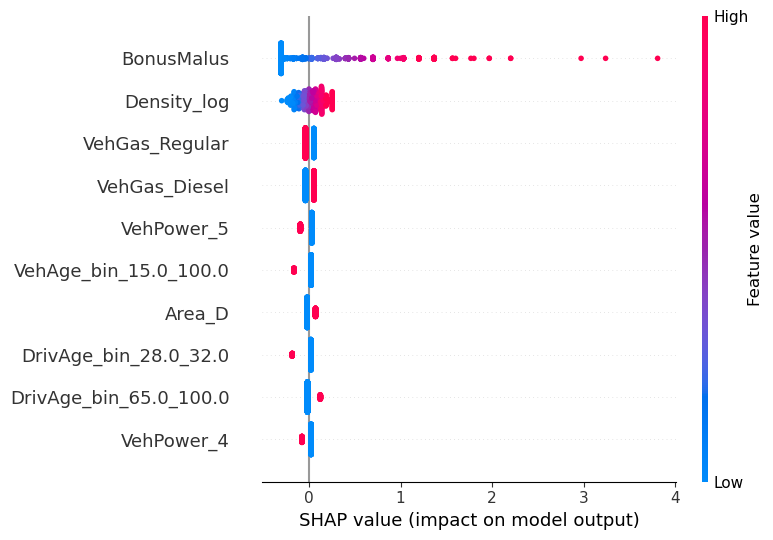

In [96]:
shap.summary_plot(
    glm_tweedie_pure_exp,
    max_display=10,
)

Während die Darstellung der Richtung des Einflüsses für die binären Merkmale sehr hilfreich ist, wirkt die Darstellung für den relativen Einfluss etwas unübersichtlich. Glücklicherweise sind SHAP-Werte additiv, so dass wir dieser wieder zusammenführen können.

In [97]:
train_cols = [
    "VehAge",
    "DrivAge",
    "VehBrand",
    "VehPower",
    "VehGas",
    "Region",
    "Area",
    "BonusMalus",
    "Density",
]

# get number of unique categories for each feature
n_categories = []
for feat in train_cols:
    if feat in ["VehAge", "DrivAge"]:
        n_categories.append(10)
    elif feat in ["VehBrand", "VehPower", "VehGas", "Region", "Area"]:
        n = df_train[feat].nunique()
        n_categories.append(n)
    elif feat in ["BonusMalus", "Density"]:
        n_categories.append(1)

n_categories

[10, 10, 11, 12, 2, 22, 6, 1, 1]

In [98]:
new_shap_values = []
for values in glm_tweedie_pure_exp.values:
    # split shap values into a list for each feature
    values_split = np.split(values, np.cumsum(n_categories))

    # sum values within each list
    values_sum = [sum(l) for l in values_split]

    new_shap_values.append(values_sum)

In [99]:
glm_tweedie_pure_exp_mod = shap.Explanation(
    values=np.array(new_shap_values)[:, :-1],
    base_values=glm_tweedie_pure_exp.base_values,
    data=df_train.loc[X_train_glm_sample.index, train_cols],
    feature_names=train_cols,
    display_data=df_train.loc[X_train_glm_sample.index, train_cols],
)

Mit den addierten SHAP-Werten kann man sich nun einen Überblick über den Gesamteinfluss eines Tarifmerkmals machen.

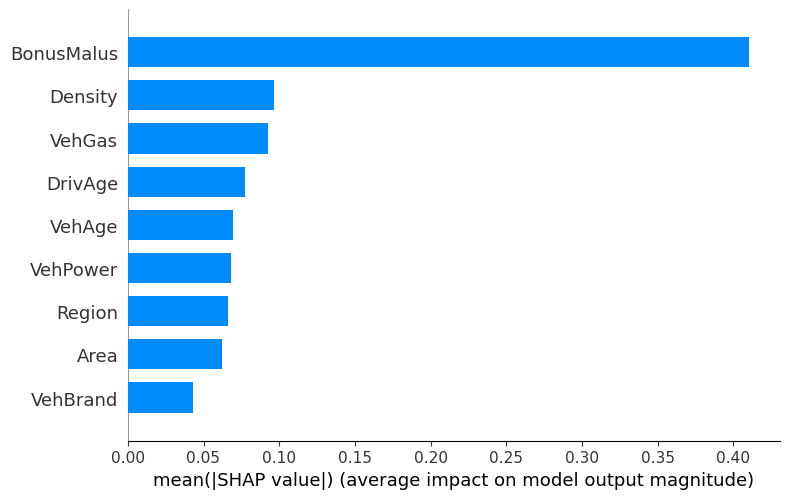

In [100]:
shap.summary_plot(glm_tweedie_pure_exp_mod, plot_type="bar")

Neben der Makroebene liefert SHAP auch die Möglichkeit, die Mikroebene zu betrachten. Hierbei wird für jede Beobachtung der Einfluss der Merkmale auf die Vorhersage dargestellt. Wir betrachten hierbei die Merkmale mit dem höchsten Einfluss.

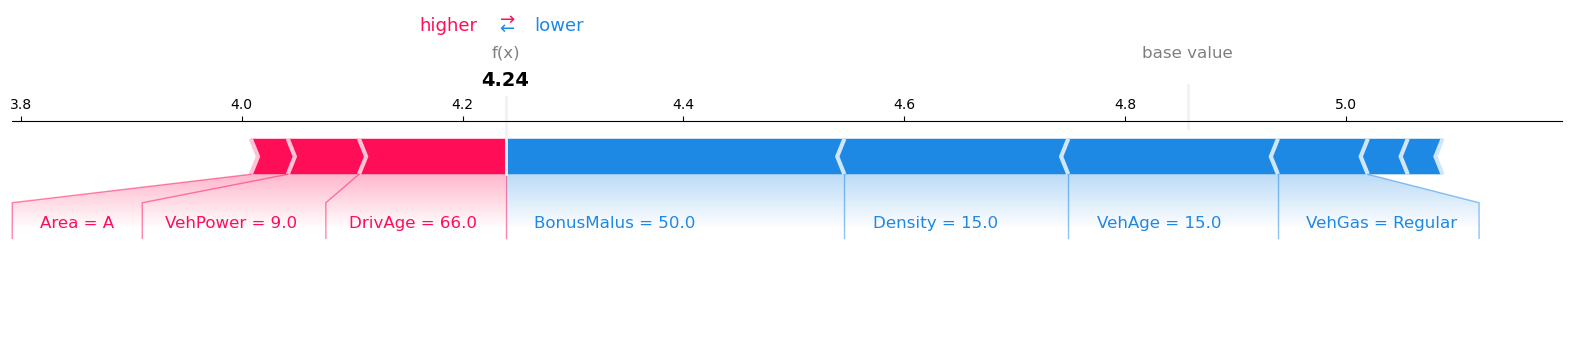

In [101]:
shap.force_plot(glm_tweedie_pure_exp_mod[2], matplotlib=True)

Die bisher verwendete Berechenungslogik der SHAP-Werte nutzt die Koeffzienten und den Interzept des GLMs. Nun sind diese auf Grund der im GLM verwendeten log-Link Funktion nicht direkt interpretierbar. Diese Methode ist zwar relativ performant, jedoch wird die Interpretierbarkeit auf relative Vergleiche beschränkt. Im Folgenden nutzen wir ein Subset, um die SHAP-Werte auf der realen Zielvariablen zu berechnen. Diese Methode ist allerdings sehr rechenintensiv.

In [102]:
glm_tweedie_pure_exp = shap.Explainer(
    glm_tweedie_pure.predict, X_train_glm_sample, output_names=feature_names_glm
)

glm_tweedie_pure_exp = glm_tweedie_pure_exp(X_train_glm_sample)

glm_tweedie_pure_exp = shap.Explanation(
    values=glm_tweedie_pure_exp.values,
    base_values=glm_tweedie_pure_exp.base_values,
    data=glm_tweedie_pure_exp.data,
    feature_names=feature_names_glm,
    display_data=glm_tweedie_pure_exp.data,
)

PermutationExplainer explainer: 1001it [01:11, 12.48it/s]                                                               


In [103]:
new_shap_values = []
for values in glm_tweedie_pure_exp.values:
    # split shap values into a list for each feature
    values_split = np.split(values, np.cumsum(n_categories))

    # sum values within each list
    values_sum = [sum(l) for l in values_split]

    new_shap_values.append(values_sum)

In [104]:
glm_tweedie_pure_exp_mod = shap.Explanation(
    values=np.array(new_shap_values)[:, :-1],
    base_values=glm_tweedie_pure_exp.base_values,
    data=df_train.loc[X_train_glm_sample.index, train_cols],
    feature_names=train_cols,
    display_data=df_train.loc[X_train_glm_sample.index, train_cols],
)

Nun erhalten wir die Erklärung im realen Wertebereich.

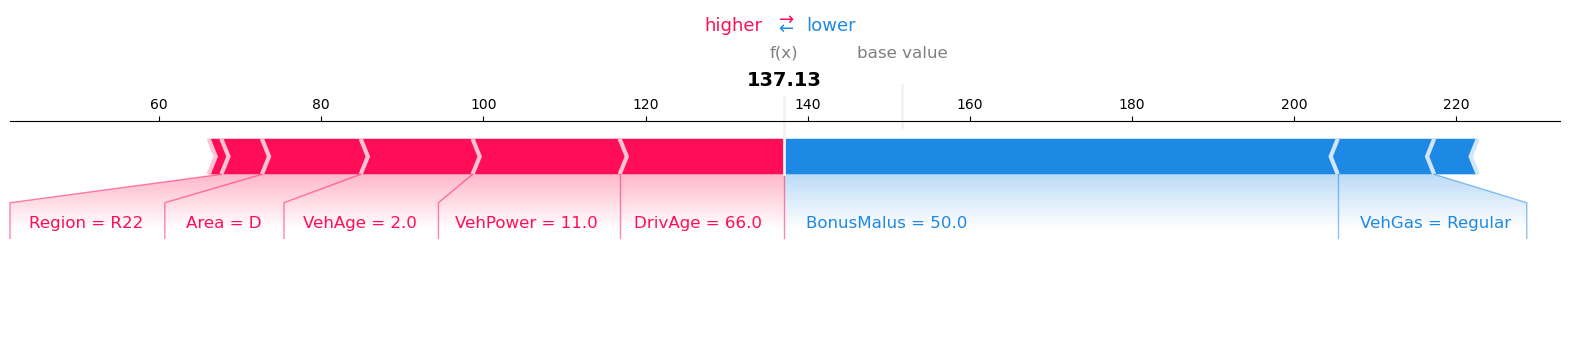

In [105]:
shap.force_plot(glm_tweedie_pure_exp_mod[0], matplotlib=True)

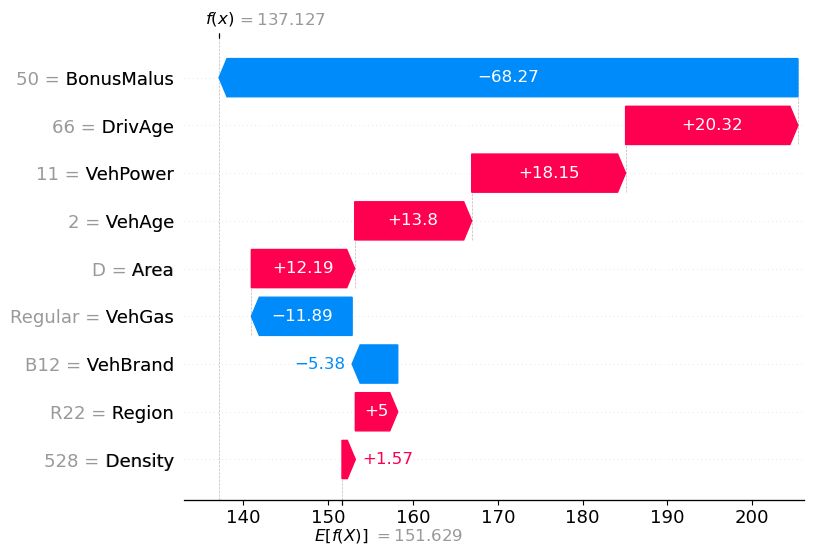

In [106]:
shap.waterfall_plot(glm_tweedie_pure_exp_mod[0])

In [107]:
glm_tweedie_pure.predict(X_train_glm_sample.iloc[0].to_frame().T)

array([137.1268435])

Auf diese Weise kann jeder € der Nettorisikoprämie für jeden einzelnen Versicherungsnehmer erklärt werden.

#### SHAP für Frequency-Severity Modelle

Frequency-Severity Modelle bestehen aus zwei getrennten Modellen für die Schadenhäufigkeit und-höhe. Zunächst müssen die SHAP-Werte für die einzelnen Modelle berechnet werden.

##### Schadenhäufigkeit

In [108]:
glm_poisson_freq_exp = shap.Explainer(
    glm_poisson_freq.predict, X_train_glm_sample, output_names=feature_names_glm
)

glm_poisson_freq_exp = glm_poisson_freq_exp(X_train_glm_sample)

glm_poisson_freq_exp = shap.Explanation(
    values=glm_poisson_freq_exp.values,
    base_values=glm_poisson_freq_exp.base_values,
    data=glm_poisson_freq_exp.data,
    feature_names=feature_names_glm,
    display_data=glm_poisson_freq_exp.data,
)

PermutationExplainer explainer: 1001it [01:06, 12.37it/s]                                                               


In [109]:
new_shap_values = []

for values in glm_poisson_freq_exp.values:
    # split shap values into a list for each feature
    values_split = np.split(values, np.cumsum(n_categories))

    # sum values within each list
    values_sum = [sum(l) for l in values_split]

    new_shap_values.append(values_sum)

In [110]:
glm_poisson_freq_exp_mod = shap.Explanation(
    values=np.array(new_shap_values)[:, :-1],
    base_values=glm_poisson_freq_exp.base_values,
    data=df_train.loc[X_train_glm_sample.index, train_cols],
    feature_names=train_cols,
    display_data=df_train.loc[X_train_glm_sample.index, train_cols],
)

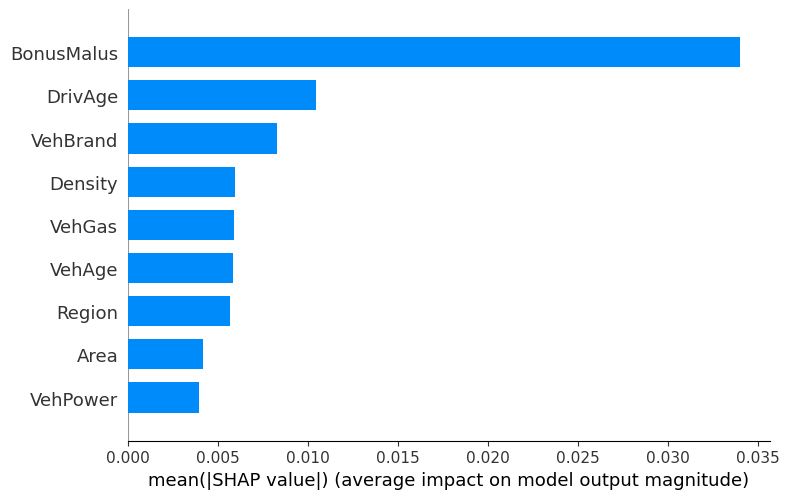

In [111]:
shap.summary_plot(glm_poisson_freq_exp_mod, plot_type="bar")

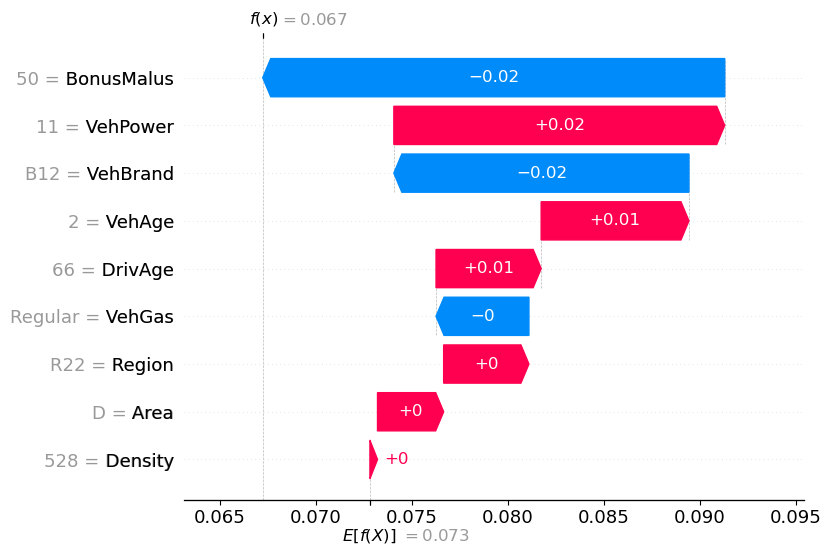

In [112]:
shap.waterfall_plot(glm_poisson_freq_exp_mod[0])

##### Schadenhöhe

In [113]:
glm_gamma_sev_exp = shap.Explainer(
    glm_gamma_sev.predict, X_train_glm_sample, output_names=feature_names_glm
)

glm_gamma_sev_exp = glm_gamma_sev_exp(X_train_glm_sample)

glm_gamma_sev_exp = shap.Explanation(
    values=glm_gamma_sev_exp.values,
    base_values=glm_gamma_sev_exp.base_values,
    data=glm_gamma_sev_exp.data,
    feature_names=feature_names_glm,
    display_data=glm_gamma_sev_exp.data,
)

PermutationExplainer explainer: 1001it [01:09, 12.10it/s]                                                               


In [114]:
new_shap_values = []

for values in glm_gamma_sev_exp.values:
    # split shap values into a list for each feature
    values_split = np.split(values, np.cumsum(n_categories))

    # sum values within each list
    values_sum = [sum(l) for l in values_split]

    new_shap_values.append(values_sum)

In [115]:
glm_gamma_sev_exp_mod = shap.Explanation(
    values=np.array(new_shap_values)[:, :-1],
    base_values=glm_gamma_sev_exp.base_values,
    data=df_train.loc[X_train_glm_sample.index, train_cols],
    feature_names=train_cols,
    display_data=df_train.loc[X_train_glm_sample.index, train_cols],
)

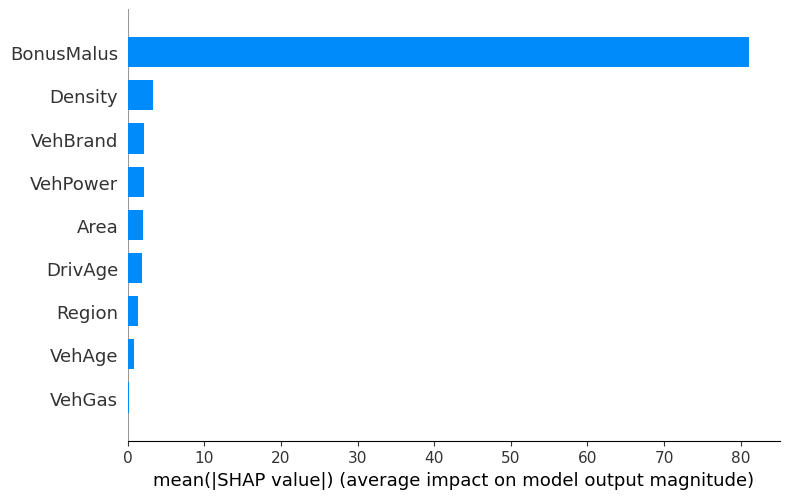

In [116]:
shap.summary_plot(glm_gamma_sev_exp_mod, plot_type="bar")

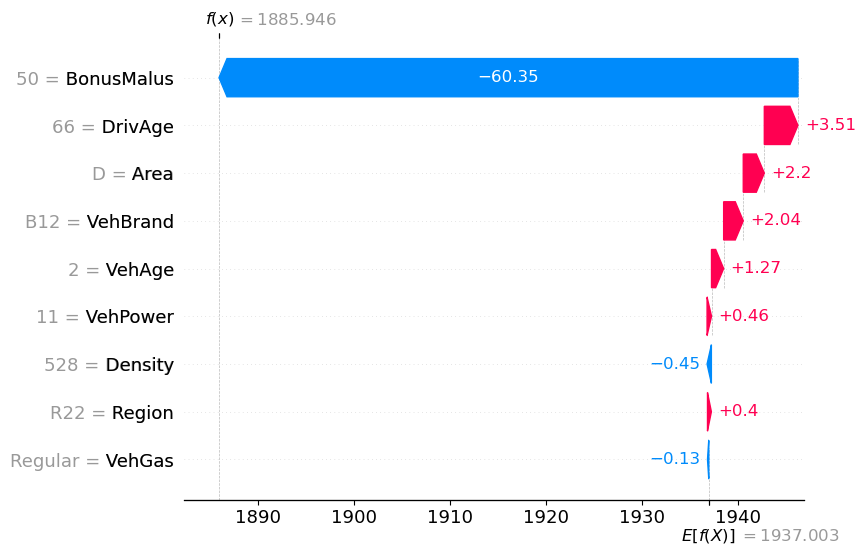

In [117]:
shap.waterfall_plot(glm_gamma_sev_exp_mod[0])

##### Kombination mittels mshap

Mshap ist eine Methode, die in der Lage ist SHAP-Werte von multiplikativ verknüpften Modellen miteinander zu verbinden.

In [118]:
from mshap import Mshap

final_shap = Mshap(
    glm_poisson_freq_exp_mod.values,
    glm_gamma_sev_exp_mod.values,
    glm_poisson_freq_exp_mod.base_values[0],
    glm_gamma_sev_exp_mod.base_values[0],
).shap_values()

In [119]:
final_shap_explanation = shap.Explanation(
    values=final_shap["shap_vals"].values,
    base_values=final_shap["expected_value"],
    data=df_train.loc[X_train_glm_sample.index, train_cols],
    feature_names=train_cols,
    display_data=df_train.loc[X_train_glm_sample.index, train_cols],
)

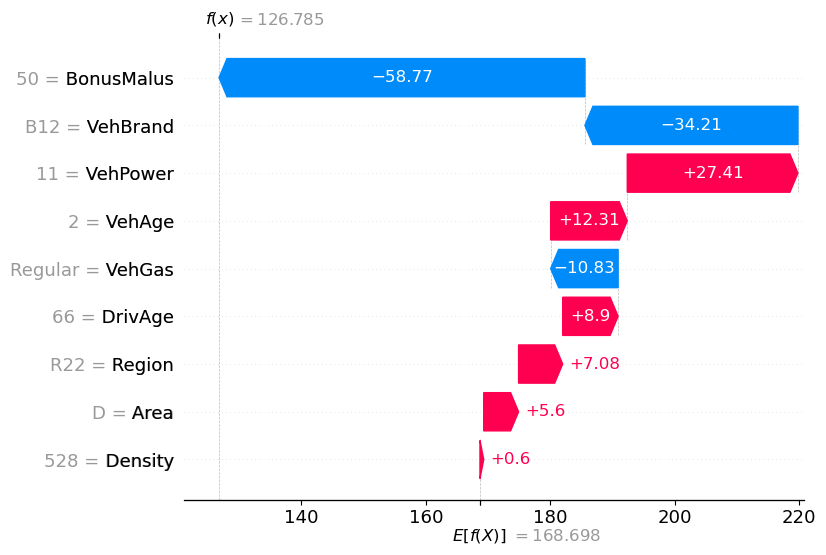

In [120]:
shap.waterfall_plot(final_shap_explanation[0])

In [121]:
glm_poisson_freq.predict(
    X_train_glm_sample.iloc[0].to_frame().T
) * glm_gamma_sev.predict(X_train_glm_sample.iloc[0].to_frame().T)

array([126.7848964])

#### SHAP für GBMs

Der TreeExplainer ist der schnellste Algorithmus, um SHAP-Werte für baumbasierte Boosting Modelle zu ermitteln.

In [122]:
n_samples = 1000
X_train_xgb_sample = X_train_xgb.sample(n_samples, random_state=42)

xgb_poisson_freq_exp = shap.TreeExplainer(
    xgb_poisson_freq,
)

xgb_poisson_freq_exp = xgb_poisson_freq_exp(X_train_xgb_sample)

xgb_poisson_freq_exp = shap.Explanation(
    values=xgb_poisson_freq_exp.values,
    base_values=xgb_poisson_freq_exp.base_values,
    data=xgb_poisson_freq_exp.data,
    feature_names=feature_names_xgb,
    display_data=df_train.loc[X_train_xgb_sample.index, feature_names_xgb],
)

[18:33:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650282415/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


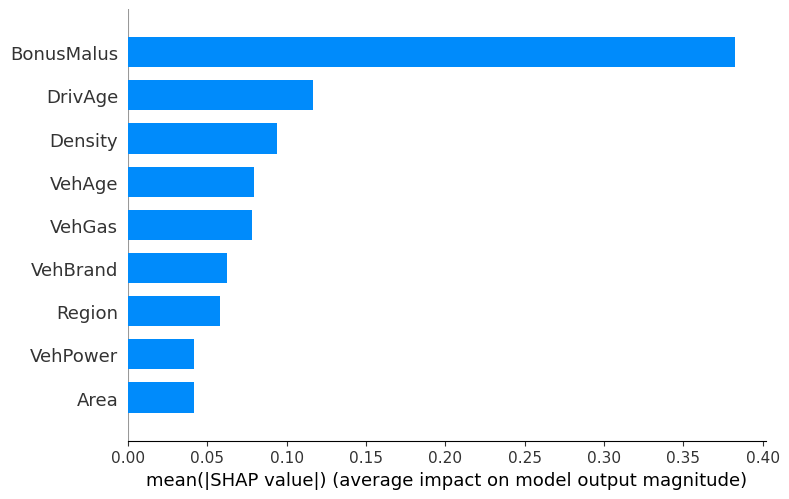

In [123]:
shap.summary_plot(xgb_poisson_freq_exp, plot_type="bar")

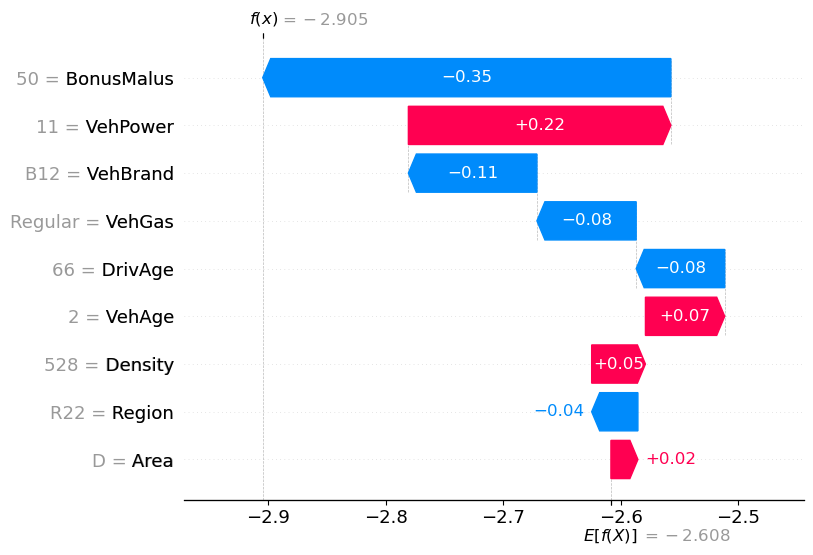

In [124]:
shap.waterfall_plot(xgb_poisson_freq_exp[0])

Wir sind an dieser Stelle mit den gleichen Herausforderungen wie beim GLM konfrontiert. Der native Algorithmus bewegt sich im log-transformierten Wertebereich und wir haben nur eine begrenzte Interpretierbarkeit.

In [125]:
xgb_poisson_freq_exp = shap.Explainer(xgb_poisson_freq.predict, X_train_xgb_sample)

xgb_poisson_freq_exp = xgb_poisson_freq_exp(X_train_xgb_sample)

xgb_poisson_freq_exp = shap.Explanation(
    values=xgb_poisson_freq_exp.values,
    base_values=xgb_poisson_freq_exp.base_values,
    data=xgb_poisson_freq_exp.data,
    feature_names=feature_names_xgb,
    display_data=df_train.loc[X_train_xgb_sample.index, feature_names_xgb],
)

ExactExplainer explainer: 1001it [02:04,  7.27it/s]                                                                     


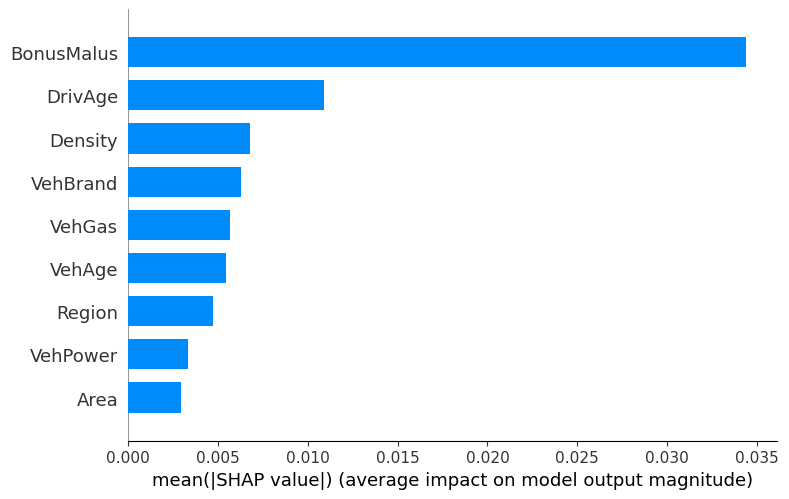

In [126]:
shap.summary_plot(xgb_poisson_freq_exp, plot_type="bar")

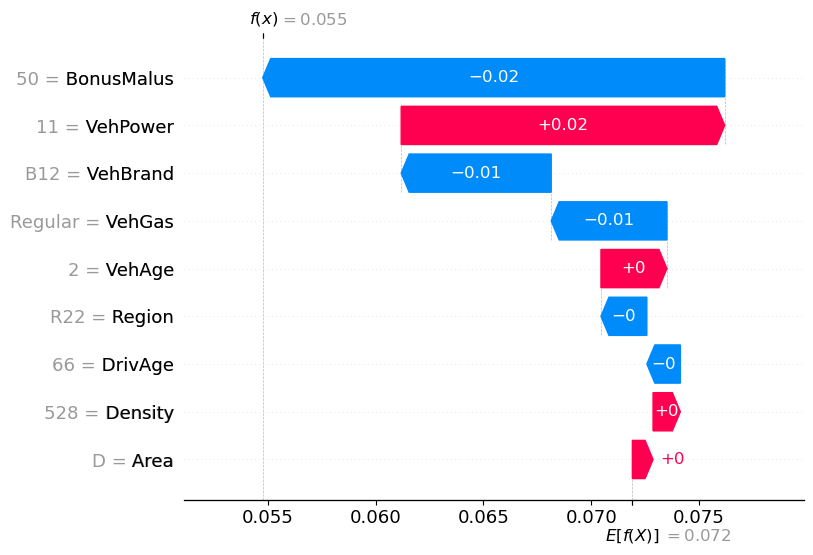

In [127]:
shap.waterfall_plot(xgb_poisson_freq_exp[0])

In [128]:
xgb_gamma_sev_exp = shap.Explainer(xgb_gamma_sev_calibrated.predict, X_train_xgb_sample)

xgb_gamma_sev_exp = xgb_gamma_sev_exp(X_train_xgb_sample)

xgb_gamma_sev_exp = shap.Explanation(
    values=xgb_gamma_sev_exp.values,
    base_values=xgb_gamma_sev_exp.base_values,
    data=xgb_gamma_sev_exp.data,
    feature_names=feature_names_xgb,
    display_data=df_train.loc[X_train_xgb_sample.index, feature_names_xgb],
)

ExactExplainer explainer: 1001it [00:42, 18.02it/s]                                                                     


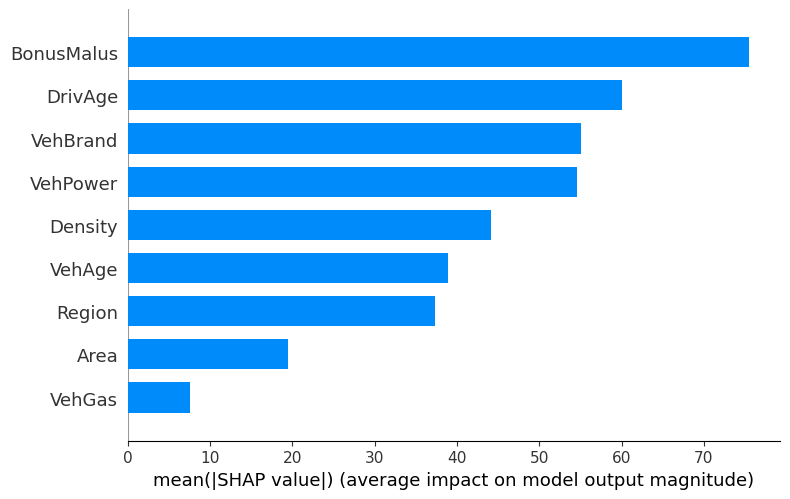

In [129]:
shap.summary_plot(xgb_gamma_sev_exp, plot_type="bar")

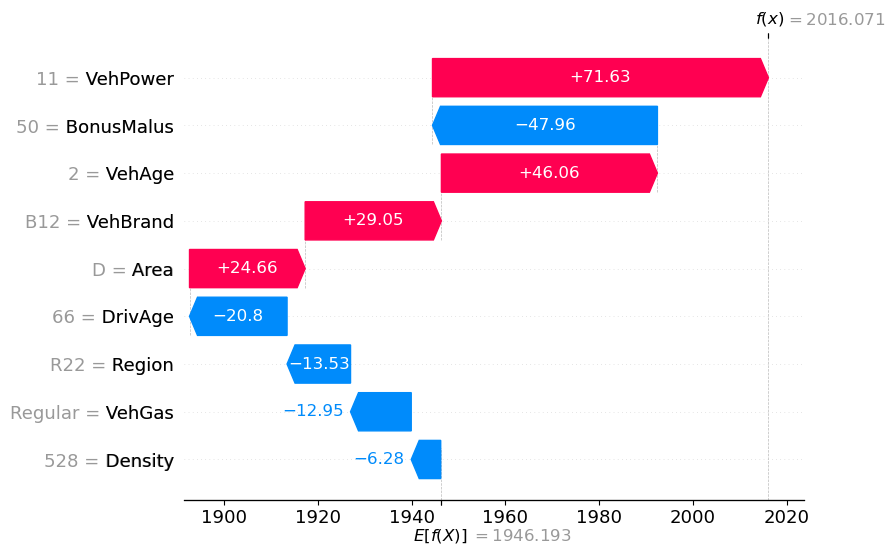

In [130]:
shap.waterfall_plot(xgb_gamma_sev_exp[0])

In [131]:
final_shap = Mshap(
    xgb_poisson_freq_exp.values,
    xgb_gamma_sev_exp.values,
    xgb_poisson_freq_exp.base_values[0],
    xgb_gamma_sev_exp.base_values[0],
).shap_values()

In [132]:
final_shap_explanation = shap.Explanation(
    values=final_shap["shap_vals"].values,
    base_values=final_shap["expected_value"],
    data=X_train_xgb_sample,
    feature_names=feature_names_xgb,
    display_data=df_train.loc[X_train_xgb_sample.index, feature_names_xgb].values,
)

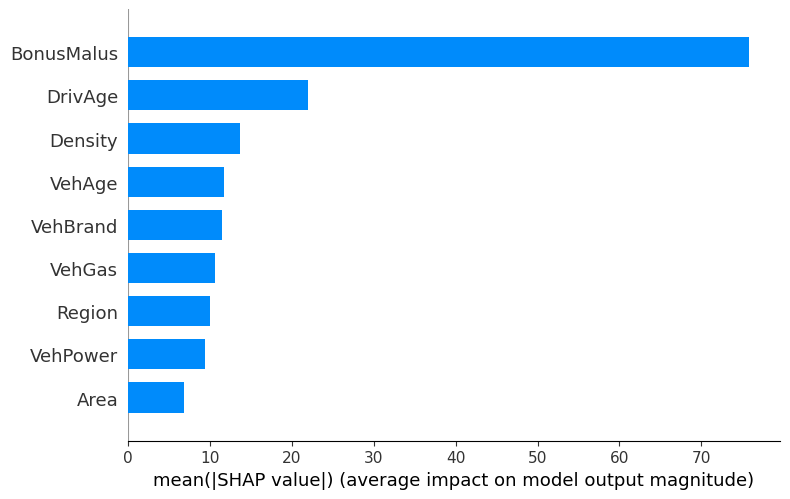

In [133]:
shap.summary_plot(final_shap_explanation, plot_type="bar")

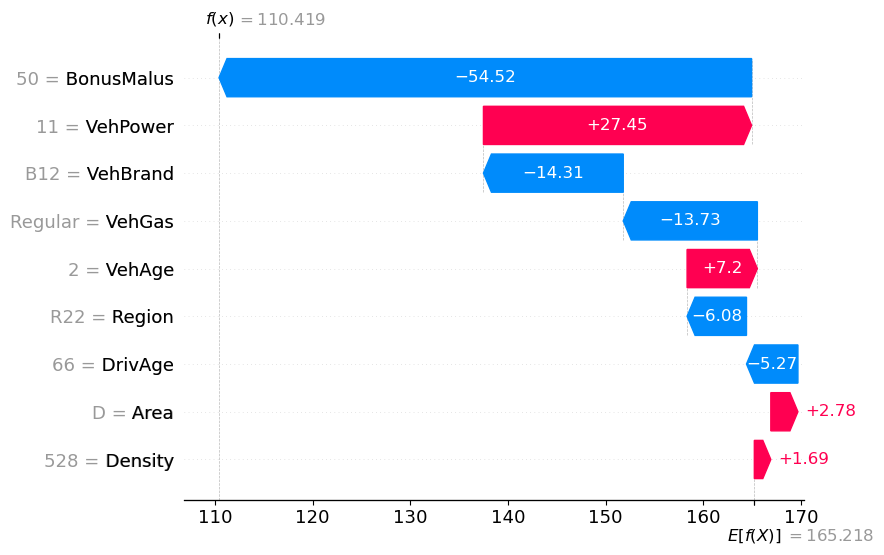

In [134]:
shap.waterfall_plot(final_shap_explanation[0])

In [135]:
xgb_poisson_freq.predict(
    X_train_xgb_sample.iloc[0].values.reshape(1, -1), validate_features=False
) * xgb_gamma_sev_calibrated.predict(
    X_train_xgb_sample.iloc[0].values.reshape(1, -1), validate_features=False
)

array([110.41886], dtype=float32)

### Partial Dependence Plots

#### PDPs mit scikit-learn

Die Machine Learning Bibliothek scikit-learn bringt eine Funktionalität zur Erstellung von Partial Dependence Plots mit sich.

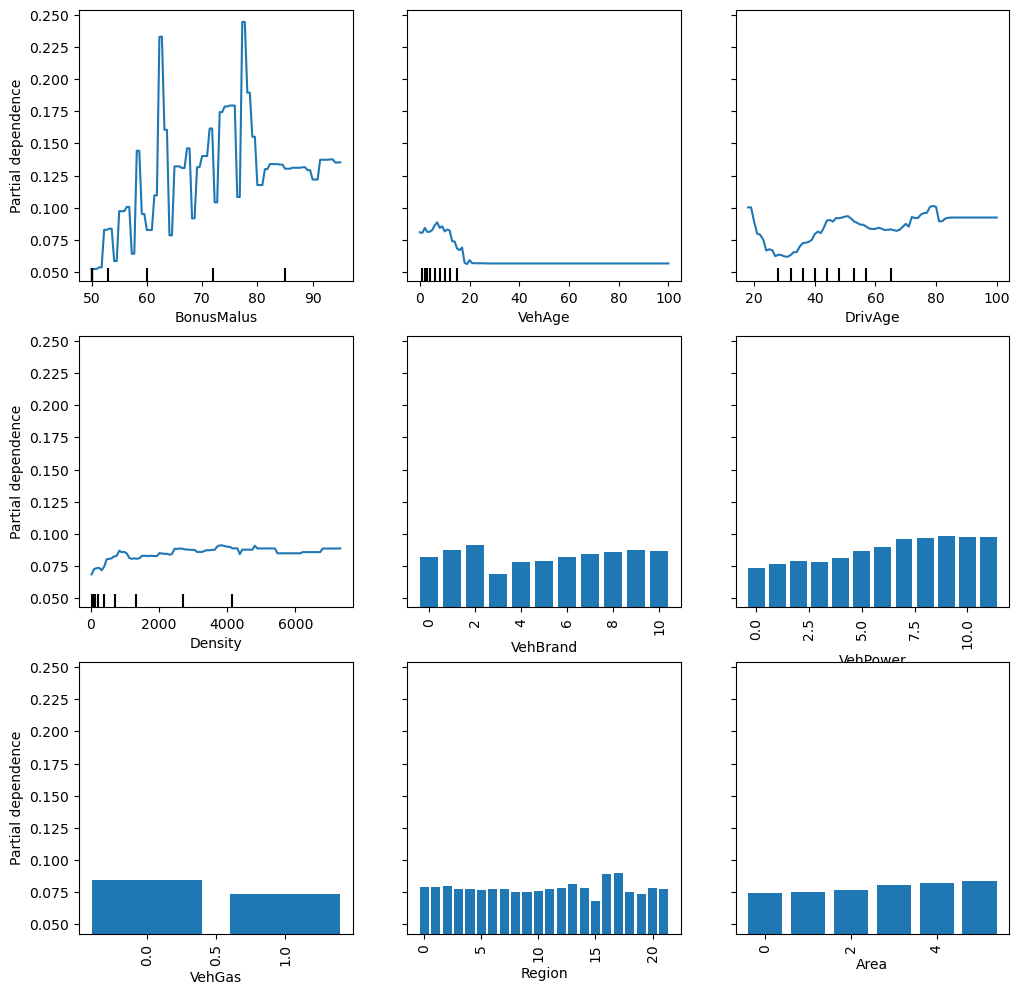

In [136]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 12))

display = PartialDependenceDisplay.from_estimator(
    xgb_poisson_freq,
    X_train_xgb,
    features=feature_names_xgb,
    kind="average",
    response_method="auto",
    categorical_features=categorical_features,
    ax=ax,
)

Diese Plots sind ausreichend, wenn man sich nur einen groben Überblick verschaffen möchte. Allerdings könne sie auch trügerisch sein, da bei der Darstellung die Varianz der Vorhersagen komplett außen vor gelassen wird. Man betrachtet nur eine Metrik.

#### PDPs mit eigener API

Die folgende Implementierung nimmt sich der Herausforderung an, auch einen Blick auf die Varianz der Vorhersagen zu werfen.

Für numerische Merkmale wird analog zur scikit-learn API der Mittelwert der Vorhersage als Linienplot dargestellt. Zusätzlich kann jedoch eine beliebige Zahl an Vorhersage-Intervallen mit geplottet werden.

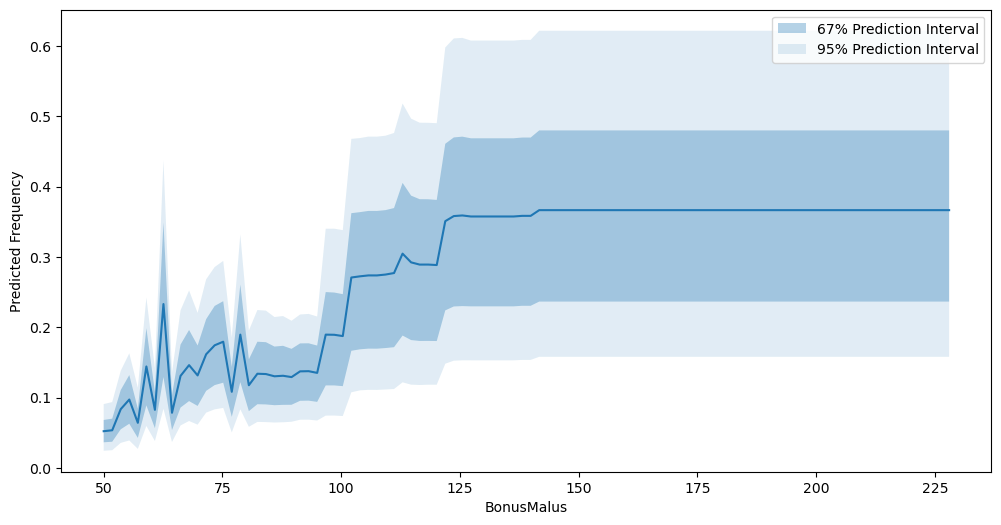

In [137]:
def _plot_num_partial_dependence(estimator, X, feature, ax, target, pi=None, **kwargs):
    """
    Generate a partial dependence plot for a given numeric feature in a dataset using XGBoost.

    Parameters:
    -----------
    estimator : scikit-learn like estimator
        A scikit-learn like estimator that has a `predict` method.
    X : pd.DataFrame
        The input samples.
    feature : str
        The name of the feature to generate the partial dependence plot for.
    ax : matplotlib axis
        The axis to plot the partial dependence plot on.
    target : str
        The name of the target variable.
    pi : int or list of ints or None, optional (default=None)
        The prediction interval(s) to plot, in percent. If None, no prediction interval is plotted.
        If a single int is passed, a single prediction interval is plotted.
        If a list of ints is passed, multiple prediction intervals are plotted.
    **kwargs : dict
        Additional arguments to pass to the plot functions.

    Returns:
    --------
    None
    """
    value_range = np.linspace(X[feature].min(), X[feature].max(), 100)
    mean_predictions = []
    pi_predictions = []
    if pi is not None:
        if isinstance(pi, int):
            pi = [pi]
        for _ in pi:
            pi_predictions.append([])
    X_mod = X.copy()
    for value in value_range:
        X_mod[feature] = value
        preds = estimator.predict(X_mod)
        mean_predictions.append(preds.mean())
        if pi is not None:
            for i, p in enumerate(pi):
                pi_predictions[i].append(
                    np.percentile(preds, [(100 - p) / 2, 50 + p / 2])
                )

    ax.plot(value_range, mean_predictions, **kwargs)
    line_color = ax.get_lines()[0].get_color()  # get color of the line in the base plot
    if pi is not None:
        for i, p in enumerate(pi):
            pi_array = np.array(pi_predictions[i])
            alpha = (
                0.1 + (1 - p / 100) * 0.7
            )  # calculate alpha based on prediction interval
            ax.fill_between(
                value_range,
                pi_array[:, 0],
                pi_array[:, 1],
                facecolor=line_color,
                alpha=alpha,
                label=f"{p}% Prediction Interval",
            )
        ax.legend()
    ax.set_xlabel(feature)
    ax.set_ylabel(f"Predicted {target}")


fig, ax = plt.subplots(figsize=(12, 6))
_plot_num_partial_dependence(
    xgb_poisson_freq,
    X_train_xgb,
    "BonusMalus",
    ax,
    target="Frequency",
    pi=[67, 95],
)

Für kategorische Merkmale kann entweder ein Box- oder Violinplot genutzt werden.

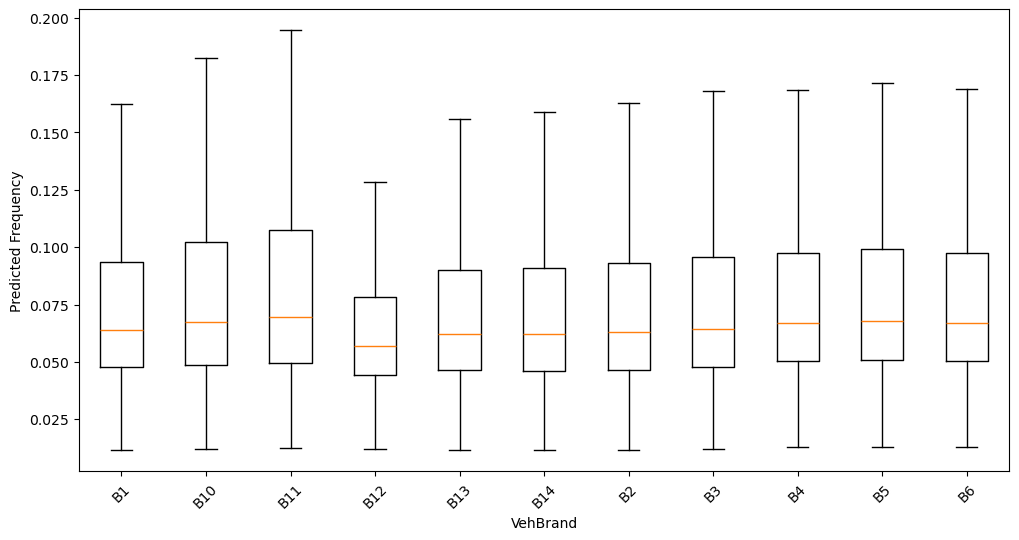

In [138]:
def _plot_cat_partial_dependence(
    estimator, X, feature, ax, target, plot_type="box", category_names=None, **kwargs
):
    """
    Generate a partial dependence plot for a given categorical feature in a dataset using XGBoost.

    Parameters:
    -----------
    estimator : scikit-learn like estimator
        A scikit-learn like estimator that has a `predict` method.
    X : array-like of shape (n_samples, n_features)
        The input samples.
    feature : str
        The name of the feature to generate the partial dependence plot for.
    ax : matplotlib axis
        The axis to plot the partial dependence plot on.
    target : str
        The name of the target variable.
    plot_type : str, optional (default='box')
        The type of plot to generate. Either 'box' or 'violin'.
    category_names : list of str, optional
        The names of the categories in the categorical feature.
    **kwargs : dict
        Additional arguments to pass to the plot functions.

    Returns:
    --------
    None
    """
    value_range = X[feature].unique()
    value_range.sort()
    predictions = []

    X_mod = X.copy()
    for value in value_range:
        X_mod[feature] = value
        preds = estimator.predict(X_mod)
        predictions.append(preds)

    if category_names is None:
        category_names = value_range

    if plot_type == "box":
        ax.boxplot(predictions, labels=category_names, showfliers=False, **kwargs)
    elif plot_type == "violin":
        ax.violinplot(predictions, showextrema=False, **kwargs)
        ax.set_xticks(np.arange(1, len(value_range) + 1))
        ax.set_xticklabels(category_names)
    else:
        raise ValueError(f"Unsupported plot type: {plot_type}")
    ax.set_xlabel(feature)
    ax.set_ylabel(f"Predicted {target}")
    ax.tick_params(axis="x", labelrotation=45)


fig, axs = plt.subplots(figsize=(12, 6))
_plot_cat_partial_dependence(
    xgb_poisson_freq,
    X_train_xgb,
    "VehBrand",
    axs[0],
    target="Frequency",
    plot_type="box",
    category_names=[
        "B1",
        "B10",
        "B11",
        "B12",
        "B13",
        "B14",
        "B2",
        "B3",
        "B4",
        "B5",
        "B6",
    ],
)
_plot_cat_partial_dependence(
    xgb_poisson_freq,
    X_train_xgb,
    "VehBrand",
    axs[1],
    target="Frequency",
    plot_type="violin",
    category_names=[
        "B1",
        "B10",
        "B11",
        "B12",
        "B13",
        "B14",
        "B2",
        "B3",
        "B4",
        "B5",
        "B6",
    ],
)
fig.tight_layout()

Für binäre Merkmale kann ebenso entweder ein Box- oder Violinplot genutzt werden. Hierbei wird berücksichtigt, dass mehrere Merkmale zussammengefasst werden müssen.

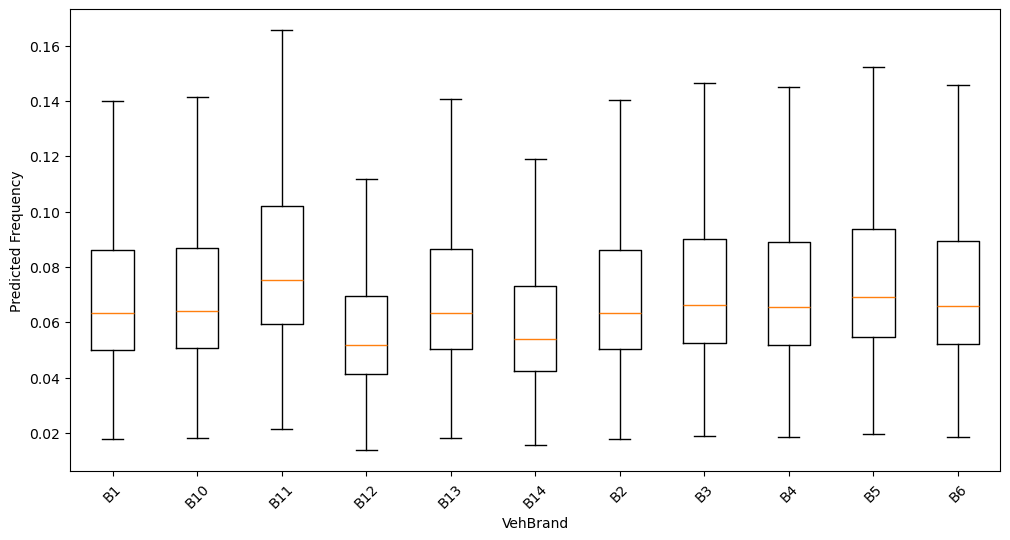

In [139]:
def _plot_bin_partial_dependence(
    estimator, X, feature, ax, target, plot_type="box", category_names=None, **kwargs
):
    """
    Generate a partial dependence plot for a given set of binary features in a dataset using XGBoost.

    Parameters:
    -----------
    estimator : scikit-learn like estimator
        A scikit-learn like estimator that has a `predict` method.
    X : array-like of shape (n_samples, n_features)
        The input samples.
    feature : str
        The name of the feature to generate the partial dependence plot for.
    ax : matplotlib axis
        The axis to plot the partial dependence plot on.
    target : str
        The name of the target variable.
    plot_type : str, optional (default='box')
        The type of plot to generate. Either 'box' or 'violin'.
    category_names : list of str, optional
        The names of the categories in the categorical feature.
    **kwargs : dict
        Additional arguments to pass to the plot functions.

    Returns:
    --------
    None
    """
    predictions = []
    bin_features = [col for col in X.columns if col.startswith(feature)]
    for bin_feature in bin_features:
        X_mod = X.copy()
        X_mod[bin_feature] = 1
        preds = estimator.predict(X_mod)
        predictions.append(preds)

    if category_names is None:
        category_names = [col.replace(f"{feature}_", "") for col in bin_features]

    if plot_type == "box":
        ax.boxplot(predictions, labels=category_names, showfliers=False, **kwargs)
    elif plot_type == "violin":
        ax.violinplot(predictions, showextrema=False, **kwargs)
        ax.set_xticks(np.arange(1, len(feature_indexes) + 1))
        ax.set_xticklabels(category_names)
    else:
        raise ValueError(f"Unsupported plot type: {plot_type}")
    ax.set_xlabel(feature)
    ax.set_ylabel(f"Predicted {target}")
    ax.tick_params(axis="x", labelrotation=45)


fig, ax = plt.subplots(figsize=(12, 6))
_plot_bin_partial_dependence(
    glm_poisson_freq,
    X_train_glm,
    "VehBrand",
    ax,
    target="Frequency",
    plot_type="box",
)

In [140]:
def plot_partial_dependence(
    estimator,
    X,
    feature,
    target="Target",
    feature_type="num",
    ax=None,
    plot_type="box",
    category_names=None,
    pi=None,
    **kwargs,
):
    """
    Generate a partial dependence plot for a given feature in a dataset using XGBoost.

    Parameters:
    -----------
    estimator : scikit-learn like estimator
        A scikit-learn like estimator that has a `predict` method.
    X : pd.DataFrame
        The input samples.
    feature : str, int
        The name of the feature to generate the partial dependence plot for.
    target : str, optional (default='Target')
        The name of the target variable.
    feature_type : str, optional (default='num')
        The type of the feature. Either 'num' or 'cat'.
    ax : matplotlib axis, optional (default=None)
        The axis to plot the partial dependence plot on. If None, a new figure and axis is created.
    plot_type : str, optional (default='box')
        The type of plot to generate for categorical features. Either 'box' or 'violin'.
    pi : int or list of ints or None, optional (default=None)
        The prediction interval(s) to plot, in percent. If None, no prediction interval is plotted.
        If a single int is passed, a single prediction interval is plotted.
        If a list of ints is passed, multiple prediction intervals are plotted.
    **kwargs : dict
        Additional arguments to pass to the plot functions.

    Returns:
    --------
    None
    """
    if ax is None:
        _, ax = plt.subplots()

    if feature_type == "num":
        _plot_num_partial_dependence(
            estimator, X, feature, ax, target=target, pi=pi, **kwargs
        )
    elif feature_type == "cat":
        _plot_cat_partial_dependence(
            estimator,
            X,
            feature,
            ax,
            target=target,
            plot_type=plot_type,
            category_names=category_names,
            **kwargs,
        )
    elif feature_type == "bin":
        _plot_bin_partial_dependence(
            estimator,
            X,
            feature,
            ax,
            target=target,
            plot_type=plot_type,
            category_names=category_names,
            **kwargs,
        )
    else:
        raise TypeError(f"Unsupported feature type: {feature_type}")

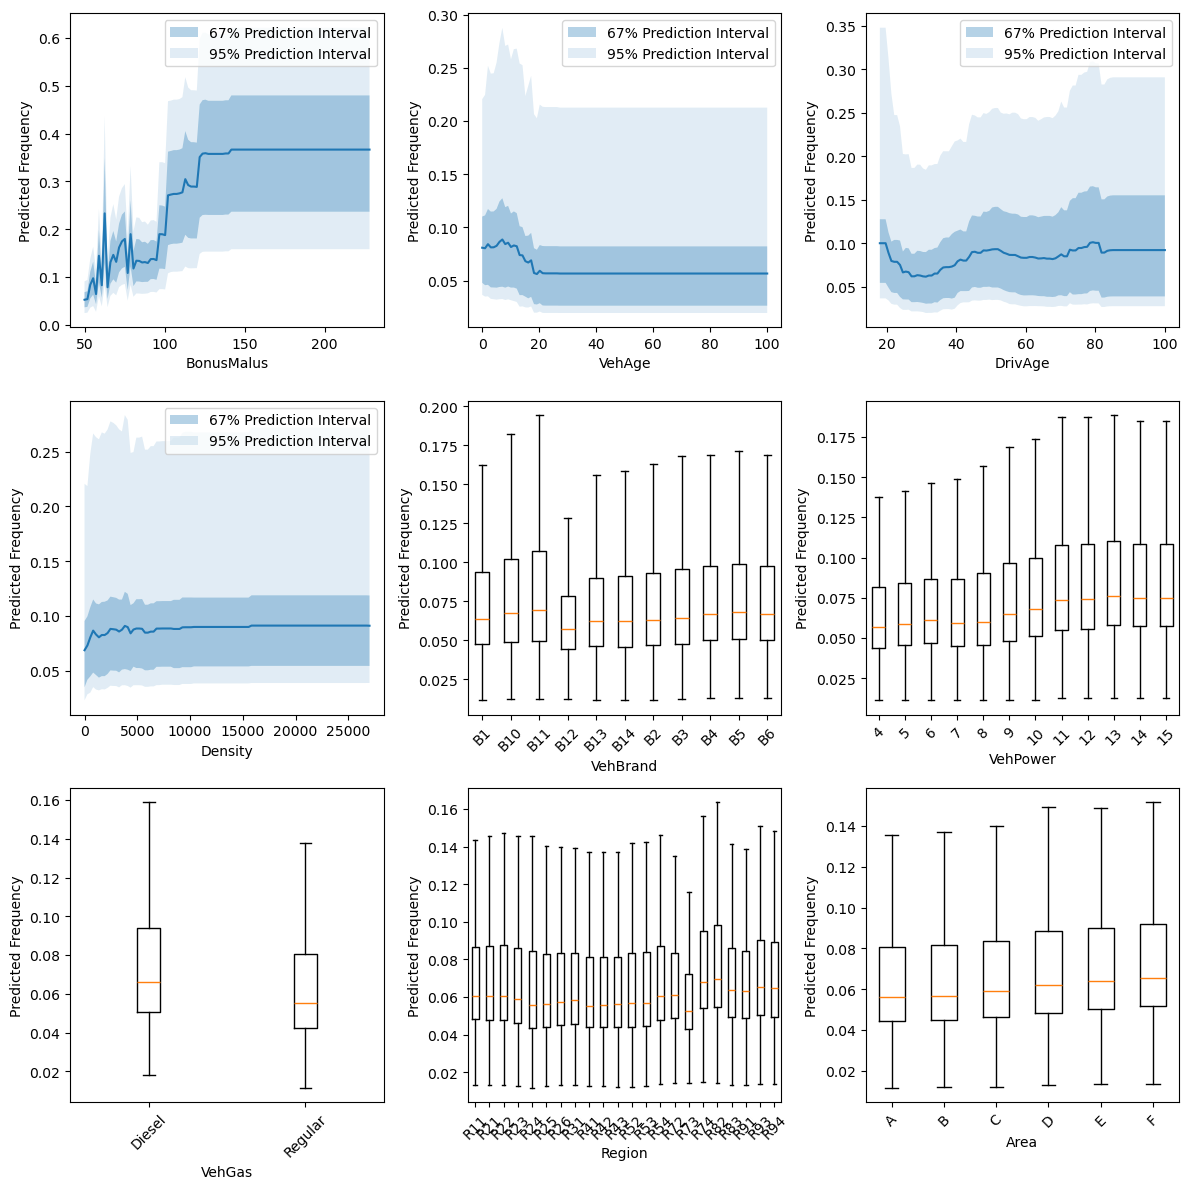

In [141]:
features = feature_names_xgb
feature_types = ["num"] * len(numeric_features) + ["cat"] * len(categorical_features)
category_names = [None] * len(numeric_features) + column_trans_xgb.named_transformers_[
    "label"
].categories_

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
for feature, feature_type, category_name, ax in zip(
    features, feature_types, category_names, axs.flatten()
):
    plot_partial_dependence(
        xgb_poisson_freq,
        X_train_xgb,
        feature,
        feature_type=feature_type,
        ax=ax,
        target="Frequency",
        plot_type="box",
        category_names=category_name,
        pi=[67, 95],
    )
fig.tight_layout()

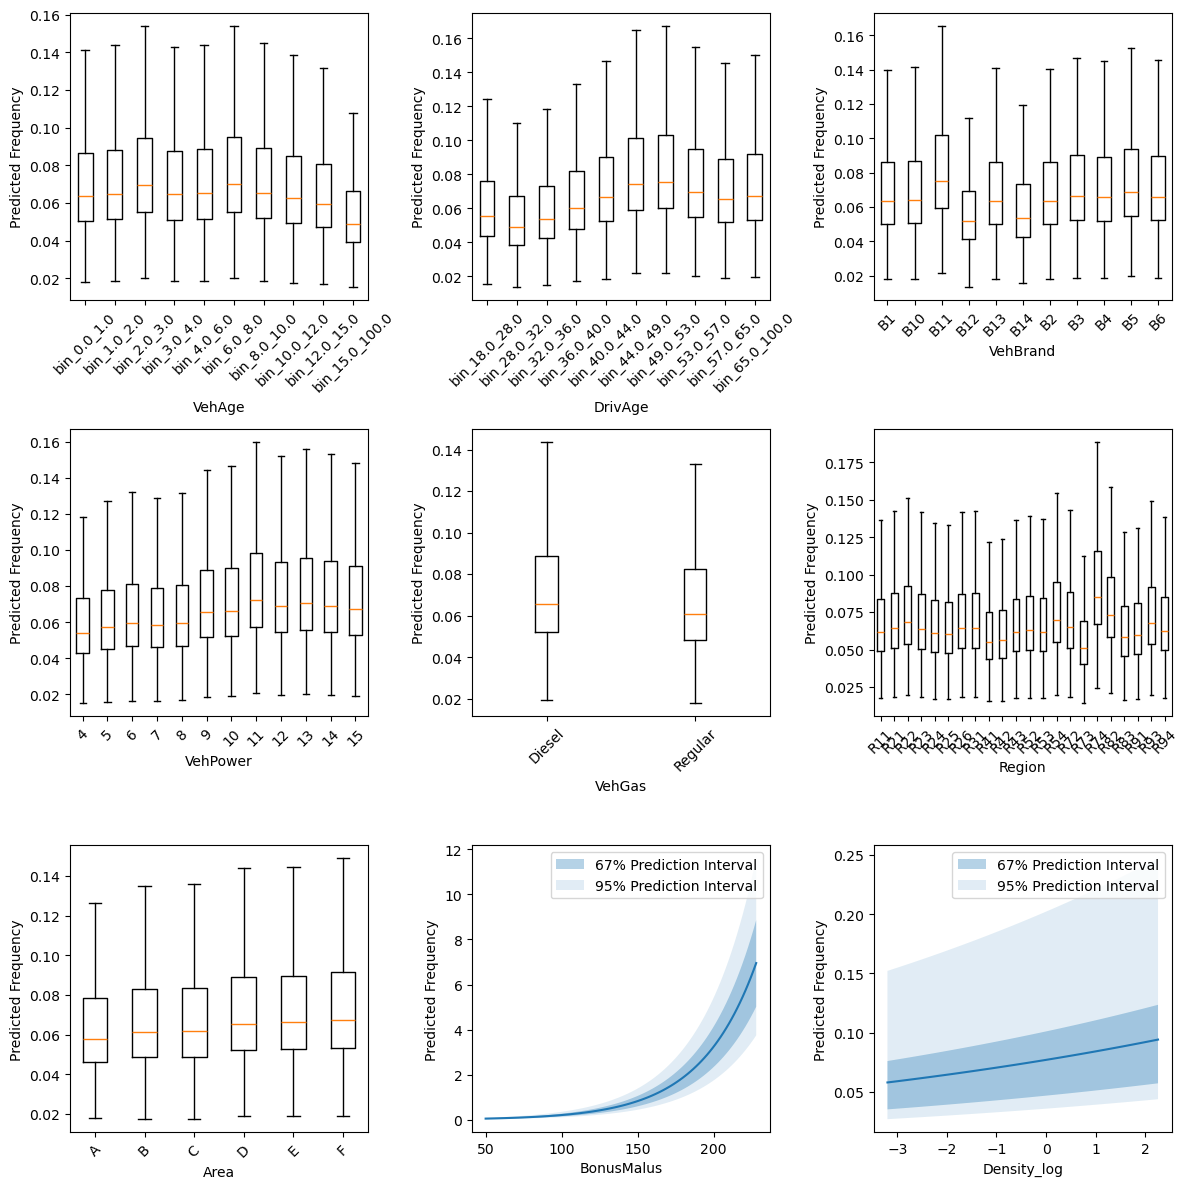

In [142]:
features = [
    "VehAge",
    "DrivAge",
    "VehBrand",
    "VehPower",
    "VehGas",
    "Region",
    "Area",
    "BonusMalus",
    "Density_log",
]
feature_types = ["bin"] * 7 + ["num"] * 2

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
for feature, feature_type, ax in zip(features, feature_types, axs.flatten()):
    plot_partial_dependence(
        glm_poisson_freq,
        X_train_glm,
        feature,
        feature_type=feature_type,
        ax=ax,
        target="Frequency",
        plot_type="box",
        pi=[67, 95],
    )
fig.tight_layout()

### Monotonie

Wir haben in den obigen Beispielen gesehen, dass die Vorhersage, ceteris paribus, für zunhemende Werte des Merkmals "BonusMalus" stark osziliert. Dieses Verhalten ist für ein der Schadenfreiheitsklasse entsprechendes Merkmal eher unerwünscht. Man erwartet hier einen monoton wachsenden Zusammenhang. Im linearen Modell kann sich ein solcher Zusammenhang entweder implzit durch die Verwendung als numerisches Tarifmerkmal ergeben oder explizit durch die Klassenbildung forciert werden. Bei Gradient Boosting Machines ist das nicht der Fall. Hier müssen wir die Monotonie als Nebenbedingung für die Baumbildung festlegen.

#### Schadenhäufigkeit

In [143]:
xgb_poisson_freq_constrained = xgb.XGBRegressor(
    objective="count:poisson",
    tree_method="hist",
    device="cuda",
    n_estimators=boost_rounds_poisson,
    n_jobs=-1,
    monotone_constraints=(1, 0, 0, 0, 0, 0, 0, 0, 0),
    **best_params_xgb_poisson,
)

xgb_poisson_freq_constrained.fit(
    X_train_xgb, df_train["Frequency"], sample_weight=df_train["Exposure"]
)

scores_xgb_poisson_freq_constrained = score_estimator(
    xgb_poisson_freq_constrained,
    X_train_xgb,
    X_test_xgb,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)

scores = pd.concat(
    [
        scores_xgb_poisson_freq_constrained,
        scores_xgb_poisson_freq,
    ],
    axis=1,
    sort=True,
    keys=(
        "XGBoost Poisson Constrained",
        "XGBoost Poisson",
    ),
)

In [144]:
scores.T.loc[(slice(None), "train"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Poisson dev,mean abs. error,mean squared error
XGBoost Poisson Constrained,0.0750,0.4427,0.1364,0.2421
XGBoost Poisson,0.0849,0.4379,0.1355,0.2414


In [145]:
scores.T.loc[(slice(None), "test"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Poisson dev,mean abs. error,mean squared error
XGBoost Poisson Constrained,0.0568,0.4494,0.1368,0.2229
XGBoost Poisson,0.0644,0.4458,0.1361,0.2224


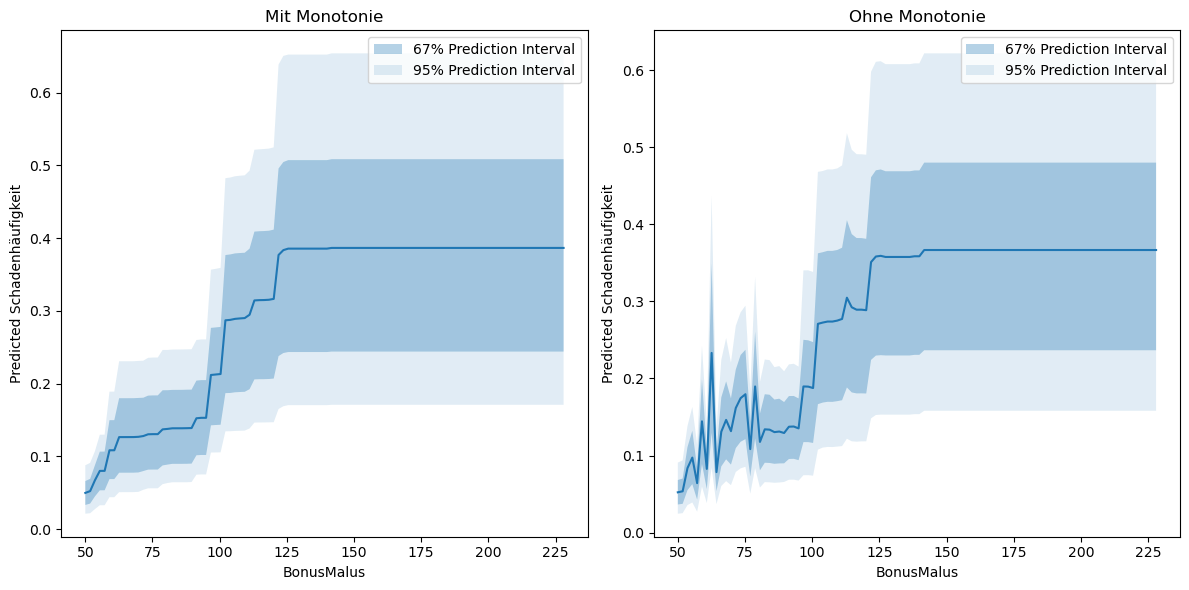

In [146]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
plot_partial_dependence(
    xgb_poisson_freq_constrained,
    X_train_xgb,
    "BonusMalus",
    feature_type="num",
    ax=axs[0],
    target="Schadenhäufigkeit",
    pi=[67, 95],
)
axs[0].set_title("Mit Monotonie")
plot_partial_dependence(
    xgb_poisson_freq,
    X_train_xgb,
    "BonusMalus",
    feature_type="num",
    ax=axs[1],
    target="Schadenhäufigkeit",
    pi=[67, 95],
)
axs[1].set_title("Ohne Monotonie")
fig.tight_layout()

#### Schadenhöhe

In [147]:
xgb_gamma_sev_constrained = xgb.XGBRegressor(
    objective="reg:gamma",
    tree_method="hist",
    device="cuda",
    n_estimators=boost_rounds_gamma,
    n_jobs=-1,
    monotone_constraints=(1, 0, 0, 0, 0, 0, 0, 0, 0),
    **best_params_xgb_gamma,
)

xgb_gamma_sev_constrained.fit(
    X_train_xgb[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

xgb_gamma_sev_calibrated_constrained = CalibratedRegressor(
    xgb_gamma_sev_constrained,
    X_train_xgb[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    weights=df_train.loc[mask_train, "ClaimNb"],
)

scores_xgb_gamma_sev_calibrated_constrained = score_estimator(
    xgb_gamma_sev_calibrated,
    X_train_xgb[mask_train.values],
    X_test_xgb[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)

scores = pd.concat(
    [
        scores_xgb_gamma_sev_calibrated_constrained,
        scores_xgb_gamma_sev,
    ],
    axis=1,
    sort=True,
    keys=(
        "XGBoost Gamma Constrained",
        "XGBoost Gamma",
    ),
)

In [148]:
scores.T.loc[(slice(None), "train"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Gamma dev,mean abs. error,mean squared error
XGBoost Gamma Constrained,0.0463,1.3741,1749.9435,5.771594e+07
XGBoost Gamma,0.0464,1.3739,1683.0390,5.773907e+07


In [149]:
scores.T.loc[(slice(None), "test"), :].droplevel(1).rename_axis(None, axis=1)

,D² explained,mean Gamma dev,mean abs. error,mean squared error
XGBoost Gamma Constrained,0.0103,1.3865,1739.2299,5.026899e+07
XGBoost Gamma,0.0088,1.3886,1670.7478,5.027763e+07


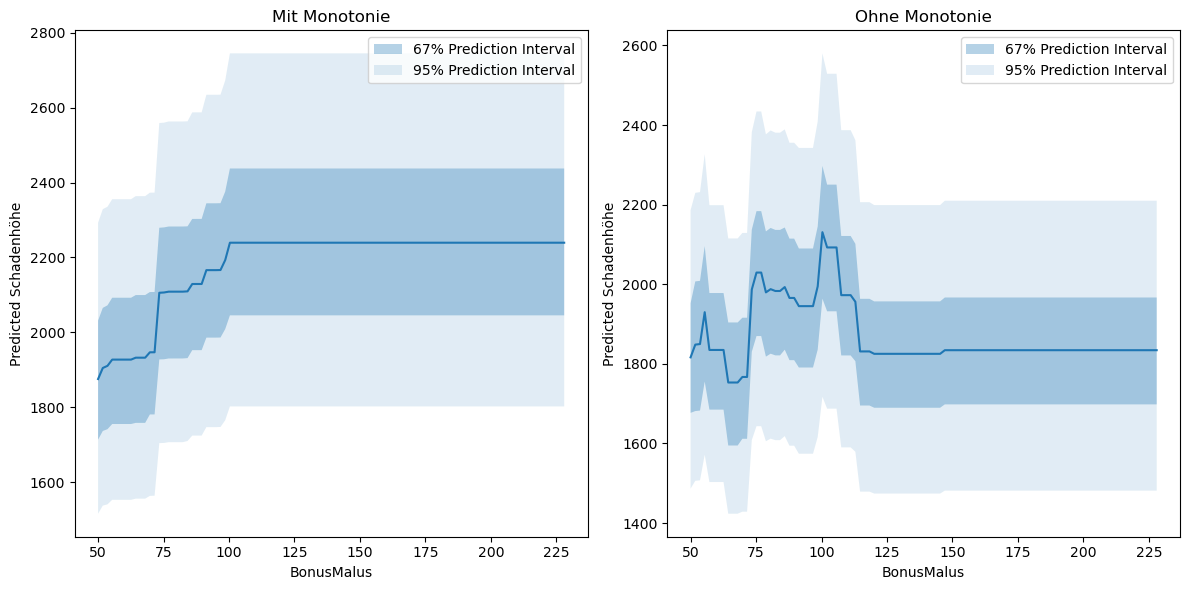

In [150]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
plot_partial_dependence(
    xgb_gamma_sev_calibrated_constrained,
    X_train_xgb,
    "BonusMalus",
    feature_type="num",
    ax=axs[0],
    target="Schadenhöhe",
    pi=[67, 95],
)
axs[0].set_title("Mit Monotonie")
plot_partial_dependence(
    xgb_gamma_sev,
    X_train_xgb,
    "BonusMalus",
    feature_type="num",
    ax=axs[1],
    target="Schadenhöhe",
    pi=[67, 95],
)
axs[1].set_title("Ohne Monotonie")
fig.tight_layout()

#### Nettorisikoprämie via Frequency-Severity

In [151]:
class ProductRegressor:
    """Wrapper for frequency - severity estimators.

    Parameters
    ----------
    est1: scikit-learn like estimator
        Scikit-learn like estimator with a `predict` method.
    est2: scikit-learn like estimator
        Scikit-learn like estimator with a `predict` method.
    """

    def __init__(self, est1, est2):
        self.est1 = est1
        self.est2 = est2

    def predict(self, X):
        """Returns the product of the individual predictions.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input data.

        Returns
        -------
        prediction : array-like of shape (n_samples,)
            The product of the individual predictions.
        """
        return self.est1.predict(X) * self.est2.predict(X)

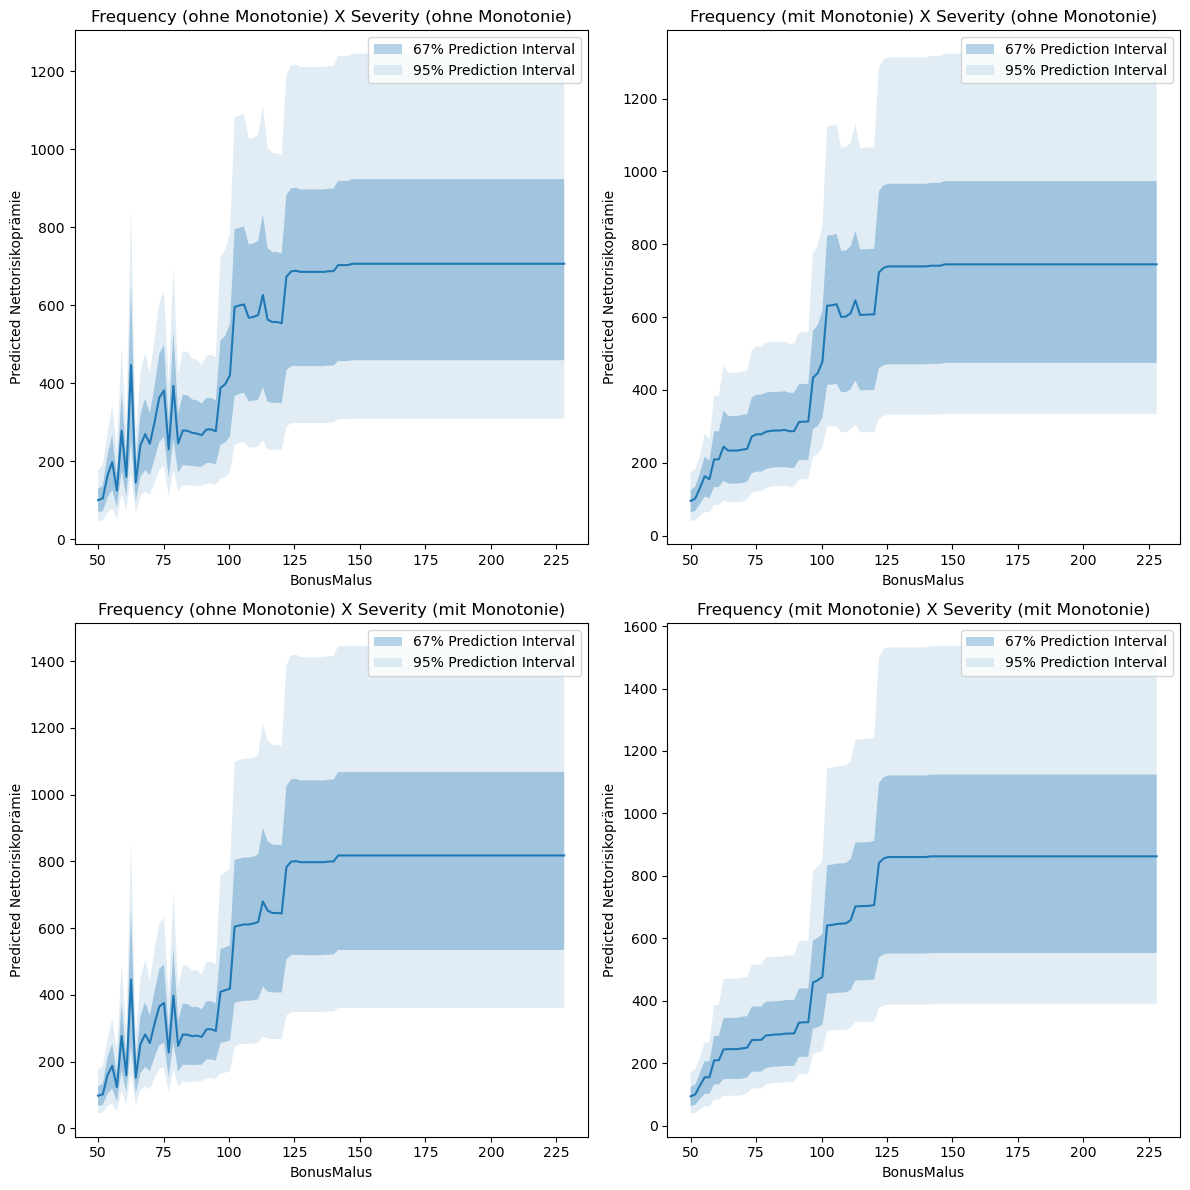

In [156]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

plot_partial_dependence(
    ProductRegressor(xgb_poisson_freq, xgb_gamma_sev_calibrated),
    X_train_xgb,
    "BonusMalus",
    feature_type="num",
    ax=axs[0][0],
    target="Nettorisikoprämie",
    pi=[67, 95],
)
axs[0][0].set_title("Frequency (ohne Monotonie) X Severity (ohne Monotonie)")

plot_partial_dependence(
    ProductRegressor(xgb_poisson_freq_constrained, xgb_gamma_sev_calibrated),
    X_train_xgb,
    "BonusMalus",
    feature_type="num",
    ax=axs[0][1],
    target="Nettorisikoprämie",
    pi=[67, 95],
)
axs[0][1].set_title("Frequency (mit Monotonie) X Severity (ohne Monotonie)")

plot_partial_dependence(
    ProductRegressor(xgb_poisson_freq, xgb_gamma_sev_calibrated_constrained),
    X_train_xgb,
    "BonusMalus",
    feature_type="num",
    ax=axs[1][0],
    target="Nettorisikoprämie",
    pi=[67, 95],
)
axs[1][0].set_title("Frequency (ohne Monotonie) X Severity (mit Monotonie)")

plot_partial_dependence(
    ProductRegressor(
        xgb_poisson_freq_constrained, xgb_gamma_sev_calibrated_constrained
    ),
    X_train_xgb,
    "BonusMalus",
    feature_type="num",
    ax=axs[1][1],
    target="Nettorisikoprämie",
    pi=[67, 95],
)
axs[1][1].set_title("Frequency (mit Monotonie) X Severity (mit Monotonie)")

fig.tight_layout()

## Glossary

<a id="claim"></a>

**Claim**: A formal request to an insurance company asking for a payment based on the terms of the insurance policy.

<a id="frequency"></a>

**Frequency**: The number of claims per policyholder or per exposure unit over a given period of time.

<a id="purepremium"></a>

**Pure Premium**: The Premium the policyholder needs to pay to cover their risk. It is calculated as the expected value of the claim amount.

<a id="severity"></a>

**Severity**: The average cost of claims, calculated as the total cost of claims divided by the total number of claims.

<a id="totalclaimamount"></a>

**Total Claim Amount**: The total amount of money an insurance company pays out for all claims.